# Neuroblastoma Gene Signature Survival Analysis in Bulk RNA-seq data

## Getting Started

In [1]:
# Code cell to be removed in the final version
from IPython.display import Javascript

keep_alive = Javascript('''
    function KeepAlive(){
        console.log("Keeping notebook alive");
        setInterval(function(){
            var xhr = new XMLHttpRequest();
            xhr.open("GET", "/", true);
            xhr.send();
        }, 60000);  // 60 seconds interval
    }
    KeepAlive();
''')

display(keep_alive)

<IPython.core.display.Javascript object>

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
import seaborn as sns
import statsmodels.api as sm

## Gene Expression Data

In [3]:
# Load gene expression data
gene_expression_file = "dataset/GSE49711_SEQC_NB_TAV_G_log2.final.txt"
gene_data = pd.read_csv(gene_expression_file, sep='\t')

In [4]:
# veiw data
gene_data.head(200)

,Gene,Gene_set,NCBI_gene_ID,RefSeq_transcript_ID,Chromosome,Strand,Start,End,SEQC_NB001,SEQC_NB002,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,2-oxoacid_dh,Gene_AceView,.,.,11,-,111933358,111934981,16.1928,16.5853,...,16.8862,17.7853,16.3760,16.9434,17.3701,17.8362,17.8373,17.4535,17.3726,16.8897
1,A1BGAS,Gene_AceView,503538,NR_015380.1,19,+,58859074,58866555,17.2744,15.3742,...,16.8690,16.7470,15.6558,16.7318,16.6318,16.4946,16.8059,16.2498,17.6346,16.8966
2,A1CF,Gene_AceView,29974,NM_001198818.1;NM_001198819.1;NM_001198820.1;N...,10,-,52566307,52645436,8.7985,0.0000,...,0.0000,10.8696,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,11.4219,0.0000
3,A2BP1,Gene_AceView,54715,NM_001142333.1;NM_001142334.1;NM_018723.3;NM_1...,16,+,6068990,7763341,16.8905,18.6162,...,14.9643,16.0162,15.5955,15.4929,17.4806,20.0256,19.4085,19.4109,20.0640,19.3468
4,A2LD1,Gene_AceView,87769,NM_001195087.1;NM_033110.2,13,-,101182342,101241782,13.8812,14.0487,...,13.9839,16.1991,14.4934,15.0323,15.1812,14.7423,14.6655,13.7998,15.1968,14.5997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ACSS2,Gene_AceView,55902,NM_001076552.2;NM_001242393.1;NM_018677.3;NM_1...,20,+,33460250,33515775,18.1079,18.6159,...,17.8572,17.7807,18.1700,18.0642,18.3047,17.9795,18.4696,18.2811,18.0744,18.3548
196,ACSS3,Gene_AceView,79611,NM_024560.2,12,+,81331595,81650746,13.8122,13.4059,...,12.2479,14.2277,12.9950,13.7934,14.3377,14.5500,14.9275,14.9621,15.0501,15.2317
197,ACTA1,Gene_AceView,58,NM_001100.3,1,-,229566986,229569840,13.2074,13.5339,...,12.3445,11.3854,11.5715,11.2827,13.3193,11.5634,12.8683,12.0049,13.4456,12.4486
198,ACTA2,Gene_AceView,59,NM_001141945.1;NM_001613.2,10,-,90694826,90751572,20.6453,19.3269,...,19.7273,22.8411,18.3877,20.7247,20.1034,21.7489,20.5502,22.1927,20.8221,21.0784


## Metadata

In [5]:
# Read and print the first few lines of the file
with open("dataset/GSE49711_series_matrix.txt", 'r') as file:
    for _ in range(66):
        print(file.readline())

!Series_title	"RNA-Seq reveals an unprecedented complexity of the neuroblastoma transcriptome and is suitable for clinical endpoint prediction [RNA-Seq]"

!Series_geo_accession	"GSE49711"

!Series_status	"Public on May 22 2015"

!Series_submission_date	"Aug 09 2013"

!Series_last_update_date	"Feb 08 2017"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_summary	"We generated gene expression profiles from 498 primary neuroblastomas using RNA-Seq and microarrays. We sought to systematically evaluate the capability of RNA deep-sequencing (RNA-Seq)-based classification for clinical endpoint prediction in comparison to microarray-based ones. The neuroblastoma cohort was randomly divided into training and validation sets, and 360 predictive models on six clinical endpoints were generated and evaluated. While prediction performances did not differ considerably between the two technical platforms, the RNA-Seq data processing pipelines, or featu

In [6]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE49711_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 66

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(50)

,!Sample_title,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,!Sample_geo_accession,GSM1205736,GSM1205737,GSM1205738,GSM1205739,GSM1205740,GSM1205741,GSM1205742,GSM1205743,GSM1205744,...,GSM1206224,GSM1206225,GSM1206226,GSM1206227,GSM1206228,GSM1206229,GSM1206230,GSM1206231,GSM1206232,GSM1206233
1,!Sample_status,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,...,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015,Public on May 22 2015
2,!Sample_submission_date,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,...,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013,Aug 09 2013
3,!Sample_last_update_date,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,...,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015,May 22 2015
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,...,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma,tissue: neuroblastoma
9,!Sample_characteristics_ch1,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,...,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2,dataset: 1,dataset: 2


In [7]:
# Read and print the first few lines of the file
with open("dataset/GSE62564_series_matrix.txt", 'r') as file:
    for _ in range(50):
        print(file.readline())

!Series_title	"An Investigation of Biomarkers Derived from Legacy Microarray Data for Their Utility in the RNA-Seq Era"

!Series_geo_accession	"GSE62564"

!Series_status	"Public on Oct 22 2014"

!Series_submission_date	"Oct 21 2014"

!Series_last_update_date	"Mar 27 2019"

!Series_pubmed_id	"25150839"

!Series_pubmed_id	"25150838"

!Series_pubmed_id	"25254650"

!Series_pubmed_id	"25633159"

!Series_summary	"Gene expression microarray has been the primary biomarker platform ubiquitously applied in biomedical research, resulting in enormous data, predictive models and biomarkers accrued. Recently, RNA-seq has looked likely to replace microarrays, but there will be a period where both technologies coexist. This raises two important questions: can microarray-based models and biomarkers be directly applied to RNA-Seq data? Can future RNA-Seq-based predictive models and biomarkers be applied to microarray data to leverage past investment? We systematically evaluated the transferability of pr

In [8]:
# Read metadata with more controlled handling
metadata_file = "dataset/GSE62564_series_matrix.txt"

# Adjusted this value based on where the data starts as showen above
skip_lines = 50

# Read the file, skipping initial lines and ensuring correct delimiter
metadata = pd.read_csv(metadata_file, sep='\t', skiprows=skip_lines)

# Display first few rows of metadata
metadata.head(100)

,!Sample_title,SEQC_NB001 [2],SEQC_NB002 [2],SEQC_NB003 [2],SEQC_NB004 [2],SEQC_NB005 [2],SEQC_NB006 [2],SEQC_NB007 [2],SEQC_NB008 [2],SEQC_NB009 [2],...,SEQC_NB489 [2],SEQC_NB490 [2],SEQC_NB491 [2],SEQC_NB492 [2],SEQC_NB493 [2],SEQC_NB494 [2],SEQC_NB495 [2],SEQC_NB496 [2],SEQC_NB497 [2],SEQC_NB498 [2]
0,!Sample_geo_accession,GSM1528894,GSM1528895,GSM1528896,GSM1528897,GSM1528898,GSM1528899,GSM1528900,GSM1528901,GSM1528902,...,GSM1529384,GSM1529385,GSM1529386,GSM1529387,GSM1529388,GSM1529389,GSM1529390,GSM1529391,GSM1529392,GSM1529393
1,!Sample_status,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,...,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014
2,!Sample_submission_date,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,...,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014
3,!Sample_last_update_date,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,...,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,...,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation
9,!Sample_characteristics_ch1,Sex: M,Sex: M,Sex: F,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: F,...,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: F,Sex: F


In [9]:
# Remove " [2]" from sample titles
metadata.columns = metadata.columns.str.replace(' \[2\]', '', regex=True)


In [10]:
# Display the first few rows to verify
metadata.head(100)

,!Sample_title,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,!Sample_geo_accession,GSM1528894,GSM1528895,GSM1528896,GSM1528897,GSM1528898,GSM1528899,GSM1528900,GSM1528901,GSM1528902,...,GSM1529384,GSM1529385,GSM1529386,GSM1529387,GSM1529388,GSM1529389,GSM1529390,GSM1529391,GSM1529392,GSM1529393
1,!Sample_status,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,...,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014,Public on Oct 22 2014
2,!Sample_submission_date,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,...,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014,Oct 21 2014
3,!Sample_last_update_date,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,...,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017,Feb 27 2017
4,!Sample_type,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,...,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA,SRA
5,!Sample_channel_count,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,!Sample_source_name_ch1,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,...,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma,neuroblastoma
7,!Sample_organism_ch1,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,...,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens,Homo sapiens
8,!Sample_characteristics_ch1,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,...,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation,training/validation: Training,training/validation: Validation
9,!Sample_characteristics_ch1,Sex: M,Sex: M,Sex: F,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: F,...,Sex: F,Sex: F,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: M,Sex: F,Sex: F


## Gene Signature Scores

### Prepare Data

In [11]:
# Extract 'os day' and 'os bin' rows and transpose the DataFrame for easier manipulation
os_day_row = metadata.iloc[13, 1:].str.split(': ').str[1].astype(int)  # Splitting and converting to integer
os_bin_row = metadata.iloc[14, 1:].str.split(': ').str[1].astype(int)

# Creating new DataFrame
data = pd.DataFrame({
    'Sample ID': metadata.columns[1:],  # Extracting Sample IDs from the column headers, skipping the first entry
    'os days': os_day_row.values,
    'os bin': os_bin_row.values
})

In [12]:
data

,Sample ID,os days,os bin
0,SEQC_NB001,1362,1
1,SEQC_NB002,2836,1
2,SEQC_NB003,1191,1
3,SEQC_NB004,2046,0
4,SEQC_NB005,220,1
...,...,...,...
493,SEQC_NB494,4828,0
494,SEQC_NB495,2467,0
495,SEQC_NB496,5780,0
496,SEQC_NB497,4883,0


### TGF Beta

In [13]:
# Read the gene list from the file
with open("dataset/HALLMARK_TGF_BETA_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
tgfb_gene_list = gene_list[2:]

# Print the gene list to verify
print(tgfb_gene_list)

['ACVR1', 'APC', 'ARID4B', 'BCAR3', 'BMP2', 'BMPR1A', 'BMPR2', 'CDH1', 'CDK9', 'CDKN1C', 'CTNNB1', 'ENG', 'FKBP1A', 'FNTA', 'FURIN', 'HDAC1', 'HIPK2', 'ID1', 'ID2', 'ID3', 'IFNGR2', 'JUNB', 'KLF10', 'LEFTY2', 'LTBP2', 'MAP3K7', 'NCOR2', 'NOG', 'PMEPA1', 'PPM1A', 'PPP1CA', 'PPP1R15A', 'RAB31', 'RHOA', 'SERPINE1', 'SKI', 'SKIL', 'SLC20A1', 'SMAD1', 'SMAD3', 'SMAD6', 'SMAD7', 'SMURF1', 'SMURF2', 'SPTBN1', 'TGFB1', 'TGFBR1', 'TGIF1', 'THBS1', 'TJP1', 'TRIM33', 'UBE2D3', 'WWTR1', 'XIAP']


In [14]:
# List of Tgfb pathway genes
tgfb_genes = tgfb_gene_list

# Calculate Tgfb signature scores for each sample
tgfb_scores = gene_data[gene_data['Gene'].isin(tgfb_genes)].iloc[:, 8:].mean(axis=0)
tgfb_scores.name = 'tgfb_score'

# Combine tgfb scores with metadata
data['tgfb_score'] = data['Sample ID'].map(tgfb_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['tgfb_score'], inplace=True)

In [15]:
tgfb_scores.head()

SEQC_NB001    18.269337
SEQC_NB002    17.887488
SEQC_NB003    17.871847
SEQC_NB004    18.281798
SEQC_NB005    18.154788
Name: tgfb_score, dtype: float64

### IL2 STAT5

In [16]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL2_STAT5_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il2_stat5_gene_list = gene_list[2:]

# Print the gene list to verify
print(il2_stat5_gene_list)

['ABCB1', 'ADAM19', 'AGER', 'AHCY', 'AHNAK', 'AHR', 'ALCAM', 'AMACR', 'ANXA4', 'APLP1', 'ARL4A', 'BATF', 'BATF3', 'BCL2', 'BCL2L1', 'BHLHE40', 'BMP2', 'BMPR2', 'CA2', 'CAPG', 'CAPN3', 'CASP3', 'CCND2', 'CCND3', 'CCNE1', 'CCR4', 'CD44', 'CD48', 'CD79B', 'CD81', 'CD83', 'CD86', 'CDC42SE2', 'CDC6', 'CDCP1', 'CDKN1C', 'CISH', 'CKAP4', 'COCH', 'COL6A1', 'CSF1', 'CSF2', 'CST7', 'CTLA4', 'CTSZ', 'CXCL10', 'CYFIP1', 'DCPS', 'DENND5A', 'DHRS3', 'DRC1', 'ECM1', 'EEF1AKMT1', 'EMP1', 'ENO3', 'ENPP1', 'EOMES', 'ETFBKMT', 'ETV4', 'F2RL2', 'FAH', 'FGL2', 'FLT3LG', 'FURIN', 'GABARAPL1', 'GADD45B', 'GALM', 'GATA1', 'GBP4', 'GLIPR2', 'GPR65', 'GPR83', 'GPX4', 'GSTO1', 'GUCY1B1', 'HIPK2', 'HK2', 'HOPX', 'HUWE1', 'HYCC2', 'ICOS', 'IFITM3', 'IFNGR1', 'IGF1R', 'IGF2R', 'IKZF2', 'IKZF4', 'IL10', 'IL10RA', 'IL13', 'IL18R1', 'IL1R2', 'IL1RL1', 'IL2RA', 'IL2RB', 'IL3RA', 'IL4R', 'IRF4', 'IRF6', 'IRF8', 'ITGA6', 'ITGAE', 'ITGAV', 'ITIH5', 'KLF6', 'LCLAT1', 'LIF', 'LRIG1', 'LRRC8C', 'LTB', 'MAFF', 'MAP3K8', 'MAP6

In [17]:
# List of il2 stat5 signaling pathway genes
il2_stat5_genes = il2_stat5_gene_list

# Calculate Tgfb signature scores for each sample
il2_stat5_scores = gene_data[gene_data['Gene'].isin(il2_stat5_genes)].iloc[:, 8:].mean(axis=0)
il2_stat5_scores.name = 'il2_stat5_score'

# Combine il2 scores with metadata
data['il2_stat5_score'] = data['Sample ID'].map(il2_stat5_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il2_stat5_score'], inplace=True)

In [18]:
il2_stat5_scores.head()

SEQC_NB001    17.244859
SEQC_NB002    16.696371
SEQC_NB003    16.120460
SEQC_NB004    17.053701
SEQC_NB005    16.878057
Name: il2_stat5_score, dtype: float64

### IL6 JAK STAT3

In [19]:
# Read the gene list from the file
with open("dataset/HALLMARK_IL6_JAK_STAT3_SIGNALING", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
il6_jak_stat3_gene_list = gene_list[2:]

# Print the gene list to verify
print(il6_jak_stat3_gene_list)

['A2M', 'ACVR1B', 'ACVRL1', 'BAK1', 'CBL', 'CCL7', 'CCR1', 'CD14', 'CD36', 'CD38', 'CD44', 'CD9', 'CNTFR', 'CRLF2', 'CSF1', 'CSF2', 'CSF2RA', 'CSF2RB', 'CSF3R', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL13', 'CXCL3', 'CXCL9', 'DNTT', 'EBI3', 'FAS', 'GRB2', 'HAX1', 'HMOX1', 'IFNAR1', 'IFNGR1', 'IFNGR2', 'IL10RB', 'IL12RB1', 'IL13RA1', 'IL15RA', 'IL17RA', 'IL17RB', 'IL18R1', 'IL1B', 'IL1R1', 'IL1R2', 'IL2RA', 'IL2RG', 'IL3RA', 'IL4R', 'IL6', 'IL6ST', 'IL7', 'IL9R', 'INHBE', 'IRF1', 'IRF9', 'ITGA4', 'ITGB3', 'JUN', 'LEPR', 'LTB', 'LTBR', 'MAP3K8', 'MYD88', 'OSMR', 'PDGFC', 'PF4', 'PIK3R5', 'PIM1', 'PLA2G2A', 'PTPN1', 'PTPN11', 'PTPN2', 'REG1A', 'SOCS1', 'SOCS3', 'STAM2', 'STAT1', 'STAT2', 'STAT3', 'TGFB1', 'TLR2', 'TNF', 'TNFRSF12A', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21', 'TYK2']


In [20]:
# List of il6 jak stat3 signaling pathway genes
il6_jak_stat3_genes = il6_jak_stat3_gene_list

# Calculate Tgfb signature scores for each sample
il6_jak_stat3_scores = gene_data[gene_data['Gene'].isin(il6_jak_stat3_genes)].iloc[:, 8:].mean(axis=0)
il6_jak_stat3_scores.name = 'il6_jak_stat3_score'

# Combine tgfb scores with metadata
data['il6_jak_stat3_score'] = data['Sample ID'].map(il6_jak_stat3_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['il6_jak_stat3_score'], inplace=True)

In [21]:
il6_jak_stat3_scores.head()

SEQC_NB001    16.482722
SEQC_NB002    15.697078
SEQC_NB003    14.869950
SEQC_NB004    15.792001
SEQC_NB005    15.197942
Name: il6_jak_stat3_score, dtype: float64

### Inflammatory Response

In [22]:
# Read the gene list from the file
with open("dataset/HALLMARK_INFLAMMATORY_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
inflammatory_gene_list = gene_list[2:]

# Print the gene list to verify
print(inflammatory_gene_list)

['ABCA1', 'ABI1', 'ACVR1B', 'ACVR2A', 'ADGRE1', 'ADM', 'ADORA2B', 'ADRM1', 'AHR', 'APLNR', 'AQP9', 'ATP2A2', 'ATP2B1', 'ATP2C1', 'AXL', 'BDKRB1', 'BEST1', 'BST2', 'BTG2', 'C3AR1', 'C5AR1', 'CALCRL', 'CCL17', 'CCL2', 'CCL20', 'CCL22', 'CCL24', 'CCL5', 'CCL7', 'CCR7', 'CCRL2', 'CD14', 'CD40', 'CD48', 'CD55', 'CD69', 'CD70', 'CD82', 'CDKN1A', 'CHST2', 'CLEC5A', 'CMKLR1', 'CSF1', 'CSF3', 'CSF3R', 'CX3CL1', 'CXCL10', 'CXCL11', 'CXCL6', 'CXCL8', 'CXCL9', 'CXCR6', 'CYBB', 'DCBLD2', 'EBI3', 'EDN1', 'EIF2AK2', 'EMP3', 'EREG', 'F3', 'FFAR2', 'FPR1', 'FZD5', 'GABBR1', 'GCH1', 'GNA15', 'GNAI3', 'GP1BA', 'GPC3', 'GPR132', 'GPR183', 'HAS2', 'HBEGF', 'HIF1A', 'HPN', 'HRH1', 'ICAM1', 'ICAM4', 'ICOSLG', 'IFITM1', 'IFNAR1', 'IFNGR2', 'IL10', 'IL10RA', 'IL12B', 'IL15', 'IL15RA', 'IL18', 'IL18R1', 'IL18RAP', 'IL1A', 'IL1B', 'IL1R1', 'IL2RB', 'IL4R', 'IL6', 'IL7R', 'INHBA', 'IRAK2', 'IRF1', 'IRF7', 'ITGA5', 'ITGB3', 'ITGB8', 'KCNA3', 'KCNJ2', 'KCNMB2', 'KIF1B', 'KLF6', 'LAMP3', 'LCK', 'LCP2', 'LDLR', 'LIF'

In [23]:
# List of inflamatory response pathway genes
inflammatory_genes = inflammatory_gene_list

# Calculate Tgfb signature scores for each sample
inflammatory_scores = gene_data[gene_data['Gene'].isin(inflammatory_genes)].iloc[:, 8:].mean(axis=0)
inflammatory_scores.name = 'inflammatory_score'

# Combine tgfb scores with metadata
data['inflammatory_score'] = data['Sample ID'].map(inflammatory_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['inflammatory_score'], inplace=True)

In [24]:
inflammatory_scores.head()

SEQC_NB001    15.634172
SEQC_NB002    15.270535
SEQC_NB003    14.382875
SEQC_NB004    15.186789
SEQC_NB005    15.045142
Name: inflammatory_score, dtype: float64

### Interferon Alpha

In [25]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_ALPHA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifna_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifna_gene_list)

['ADAR', 'B2M', 'BATF2', 'BST2', 'C1S', 'CASP1', 'CASP8', 'CCRL2', 'CD47', 'CD74', 'CMPK2', 'CMTR1', 'CNP', 'CSF1', 'CXCL10', 'CXCL11', 'DDX60', 'DHX58', 'EIF2AK2', 'ELF1', 'EPSTI1', 'GBP2', 'GBP4', 'GMPR', 'HELZ2', 'HERC6', 'HLA-C', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT2', 'IFIT3', 'IFITM1', 'IFITM2', 'IFITM3', 'IL15', 'IL4R', 'IL7', 'IRF1', 'IRF2', 'IRF7', 'IRF9', 'ISG15', 'ISG20', 'LAMP3', 'LAP3', 'LGALS3BP', 'LPAR6', 'LY6E', 'MOV10', 'MVB12A', 'MX1', 'NCOA7', 'NMI', 'NUB1', 'OAS1', 'OASL', 'OGFR', 'PARP12', 'PARP14', 'PARP9', 'PLSCR1', 'PNPT1', 'PROCR', 'PSMA3', 'PSMB8', 'PSMB9', 'PSME1', 'PSME2', 'RIPK2', 'RNF31', 'RSAD2', 'RTP4', 'SAMD9', 'SAMD9L', 'SELL', 'SLC25A28', 'SP110', 'STAT2', 'TAP1', 'TDRD7', 'TENT5A', 'TMEM140', 'TRAFD1', 'TRIM14', 'TRIM21', 'TRIM25', 'TRIM26', 'TRIM5', 'TXNIP', 'UBA7', 'UBE2L6', 'USP18', 'WARS1']


In [26]:
# List of ifng response pathway genes
ifna_genes = ifna_gene_list

# Calculate Tgfb signature scores for each sample
ifna_scores = gene_data[gene_data['Gene'].isin(ifna_genes)].iloc[:, 8:].mean(axis=0)
ifna_scores.name = 'ifna_score'

# Combine tgfb scores with metadata
data['ifna_score'] = data['Sample ID'].map(ifna_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifna_score'], inplace=True)

In [27]:
ifna_scores.head()

SEQC_NB001    18.813415
SEQC_NB002    17.277249
SEQC_NB003    16.387085
SEQC_NB004    17.403907
SEQC_NB005    17.422367
Name: ifna_score, dtype: float64

### Interferon Gamma

In [28]:
# Read the gene list from the file
with open("dataset/HALLMARK_INTERFERON_GAMMA_RESPONSE", 'r') as file:
    gene_list = file.read().splitlines()

# Remove the first two lines (title and URL)
ifng_gene_list = gene_list[2:]

# Print the gene list to verify
print(ifng_gene_list)

['ADAR', 'APOL6', 'ARID5B', 'ARL4A', 'AUTS2', 'B2M', 'BANK1', 'BATF2', 'BPGM', 'BST2', 'BTG1', 'C1R', 'C1S', 'CASP1', 'CASP3', 'CASP4', 'CASP7', 'CASP8', 'CCL2', 'CCL5', 'CCL7', 'CD274', 'CD38', 'CD40', 'CD69', 'CD74', 'CD86', 'CDKN1A', 'CFB', 'CFH', 'CIITA', 'CMKLR1', 'CMPK2', 'CMTR1', 'CSF2RB', 'CXCL10', 'CXCL11', 'CXCL9', 'DDX60', 'DHX58', 'EIF2AK2', 'EIF4E3', 'EPSTI1', 'FAS', 'FCGR1A', 'FGL2', 'FPR1', 'GBP4', 'GBP6', 'GCH1', 'GPR18', 'GZMA', 'HELZ2', 'HERC6', 'HIF1A', 'HLA-A', 'HLA-B', 'HLA-DMA', 'HLA-DQA1', 'HLA-DRB1', 'HLA-G', 'ICAM1', 'IDO1', 'IFI27', 'IFI30', 'IFI35', 'IFI44', 'IFI44L', 'IFIH1', 'IFIT1', 'IFIT2', 'IFIT3', 'IFITM2', 'IFITM3', 'IFNAR2', 'IL10RA', 'IL15', 'IL15RA', 'IL18BP', 'IL2RB', 'IL4R', 'IL6', 'IL7', 'IRF1', 'IRF2', 'IRF4', 'IRF5', 'IRF7', 'IRF8', 'IRF9', 'ISG15', 'ISG20', 'ISOC1', 'ITGB7', 'JAK2', 'KLRK1', 'LAP3', 'LATS2', 'LCP2', 'LGALS3BP', 'LY6E', 'LYSMD2', 'MARCHF1', 'METTL7B', 'MT2A', 'MTHFD2', 'MVP', 'MX1', 'MX2', 'MYD88', 'NAMPT', 'NCOA3', 'NFKB1', 'N

In [29]:
# List of ifng response pathway genes
ifng_genes = ifng_gene_list

# Calculate Tgfb signature scores for each sample
ifng_scores = gene_data[gene_data['Gene'].isin(ifng_genes)].iloc[:, 8:].mean(axis=0)
ifng_scores.name = 'ifng_score'

# Combine tgfb scores with metadata
data['ifng_score'] = data['Sample ID'].map(ifng_scores)

# Drop samples with missing tgfb scores
data.dropna(subset=['ifng_score'], inplace=True)

In [30]:
ifng_scores.head()

SEQC_NB001    18.199822
SEQC_NB002    17.047478
SEQC_NB003    16.125509
SEQC_NB004    17.065319
SEQC_NB005    16.811052
Name: ifng_score, dtype: float64

### Final Data

In [31]:
# Display the data to verify
data.head(100)

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052
...,...,...,...,...,...,...,...,...,...
95,SEQC_NB096,3977,0,18.028390,16.771964,15.684321,15.271098,17.187849,16.908194
96,SEQC_NB097,3641,0,18.449957,17.387568,16.648688,15.945750,17.541887,17.449249
97,SEQC_NB098,4042,0,17.734043,16.430237,14.934844,14.424689,16.293699,16.074294
98,SEQC_NB099,2167,0,18.278833,17.052905,16.150145,15.524826,16.976634,16.748258


## Survival Analysis

### Quantile Survival Analysis
- **Kaplan-Meier Plot**: The Kaplan-Meier plot will show the survival probability over time for the top 25% and bottom 25% of Tgfb scores.
- **Log-Rank Test**: Perform a log-rank test to determine if the difference in survival between the two groups is statistically significant.

### Continuous Survival Analysis

- **Cox proportional hazards regression model**: The CoxPHFitter from the lifelines package fits a Cox proportional hazards regression model to the data. This model relates the time that passes before an event occurs to the predictor variables, in this case, the continuous TGF-β score.


### TGF Beta

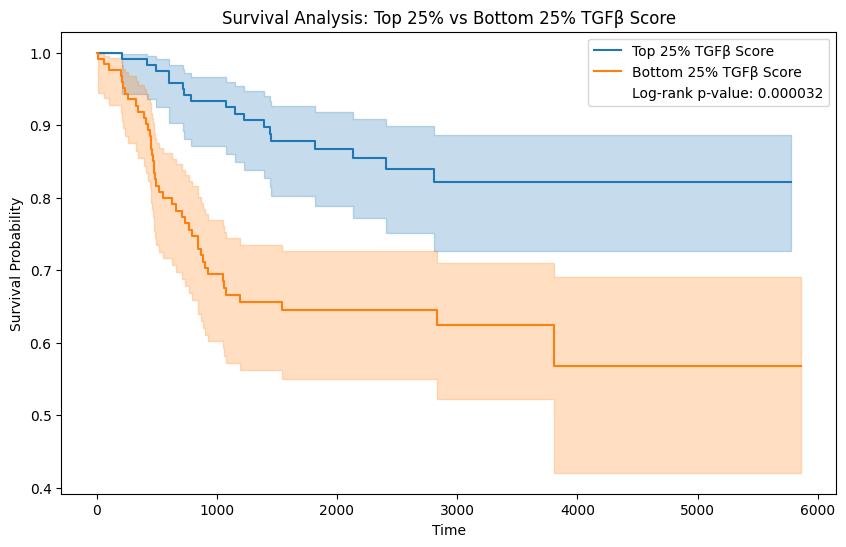

In [32]:
# Stratify samples into top 25% and bottom 25% based on tgfb_score
top_25 = data[data['tgfb_score'] >= data['tgfb_score'].quantile(0.75)]
bottom_25 = data[data['tgfb_score'] <= data['tgfb_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFβ score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFβ Score')
ax = kmf.plot_survival_function()

# Bottom 25% TGFβ score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFβ Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFβ Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFβ Score', f'Bottom 25% TGFβ Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -617.62
         time fit was run = 2024-06-10 14:46:08 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
tgfb_score  -1.06       0.35       0.24            -1.53            -0.59                 0.22                 0.55

             cmp to     z      p   -log2(p)
covariate                                  
tgfb_score     0.00 -4.41 <0.005      16.55
---
Concordance = 0.64
Partial AIC = 1237.23
log-likelihood ratio test = 17.94 on 1 df
-log2(p) of ll-ratio test = 15.42

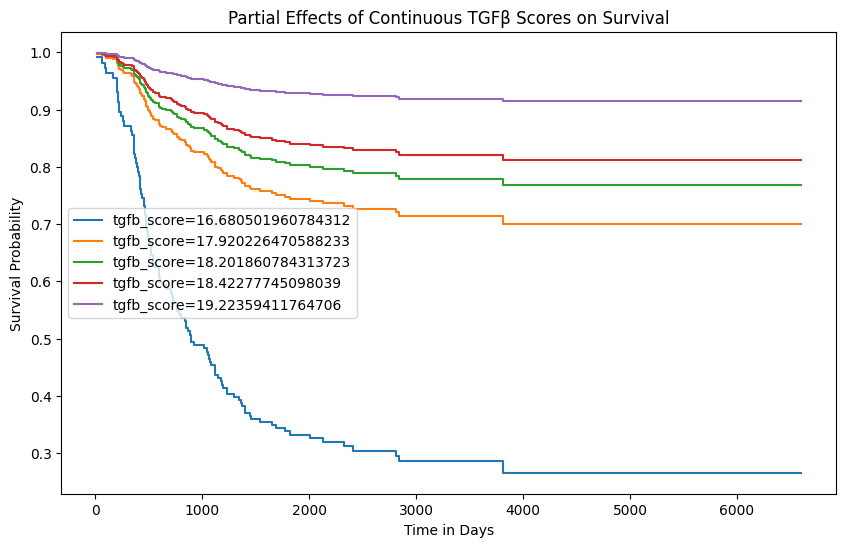

In [33]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'tgfb_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of TGFβ scores on survival
cph.plot_partial_effects_on_outcome(covariates='tgfb_score', values=[cox_data['tgfb_score'].min(), cox_data['tgfb_score'].quantile(0.25), cox_data['tgfb_score'].median(), cox_data['tgfb_score'].quantile(0.75), cox_data['tgfb_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFβ Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [34]:
# Identify the minimum TGFB expression level
min_tgfb_score = data['tgfb_score'].min()

# Count how many patients have this minimum expression level
count_min_score = (data['tgfb_score'] == min_tgfb_score).sum()

# Print the result
print(f"Number of patients with the lowest TGFB1 expression level ({min_tgfb_score}): {count_min_score}")

Number of patients with the lowest TGFB1 expression level (16.680501960784312): 1


In [35]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['tgfb_score'] == min_tgfb_score]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB score:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB score:
      Sample ID
439  SEQC_NB440


### IL2 STAT5

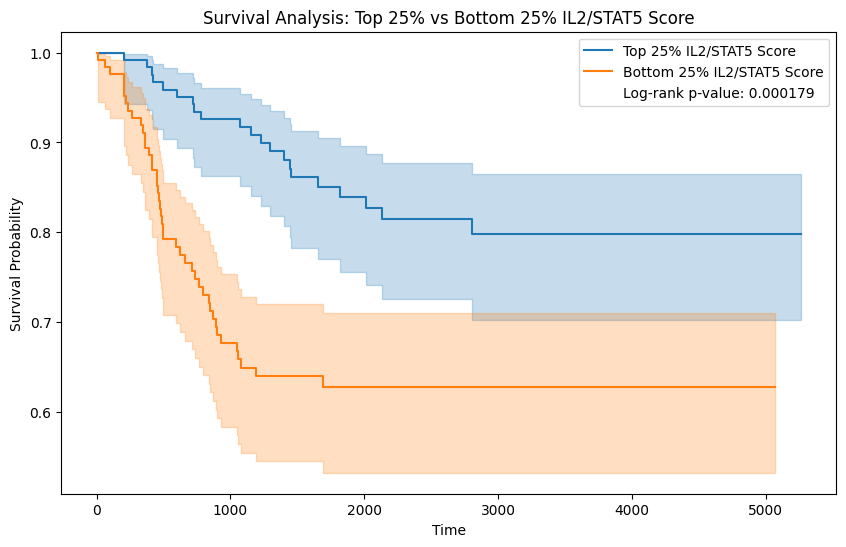

In [36]:
# Stratify samples into top 25% and bottom 25% based on il2_stat5_score
top_25 = data[data['il2_stat5_score'] >= data['il2_stat5_score'].quantile(0.75)]
bottom_25 = data[data['il2_stat5_score'] <= data['il2_stat5_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL2/STAT5 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL2/STAT5 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL2/STAT5 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL2/STAT5 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL2/STAT5 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL2/STAT5 Score', f'Bottom 25% IL2/STAT5 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -612.82
         time fit was run = 2024-06-10 14:46:08 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
il2_stat5_score  -0.90       0.41       0.16            -1.22            -0.59                 0.30                 0.56

                  cmp to     z      p   -log2(p)
covariate                                       
il2_stat5_score     0.00 -5.63 <0.005      25.70
---
Concordance = 0.65
Partial AIC = 1227.64
log-likelihood ratio test = 27.53 on 1 df
-log2(p) of ll-ratio test = 22.62

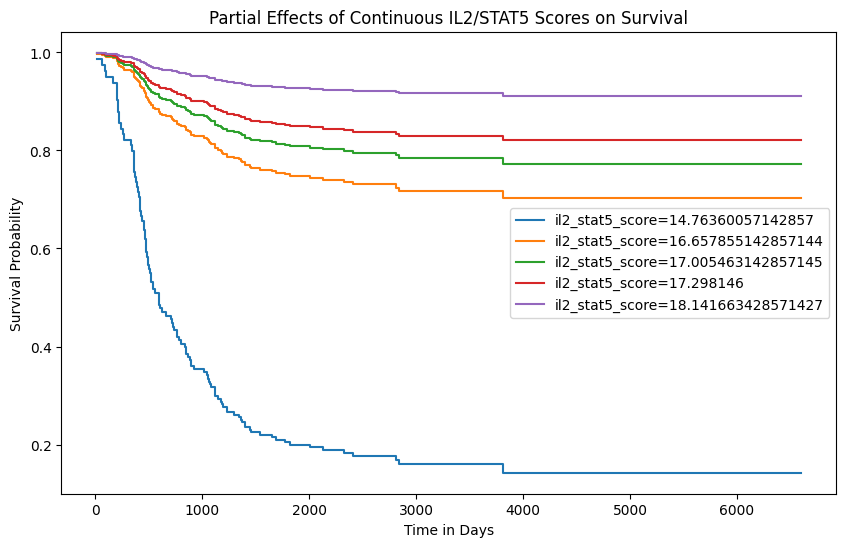

In [37]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il2_stat5_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL2/STAT5 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il2_stat5_score', values=[cox_data['il2_stat5_score'].min(), cox_data['il2_stat5_score'].quantile(0.25), cox_data['il2_stat5_score'].median(), cox_data['il2_stat5_score'].quantile(0.75), cox_data['il2_stat5_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL2/STAT5 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IL6 JAK STAT3

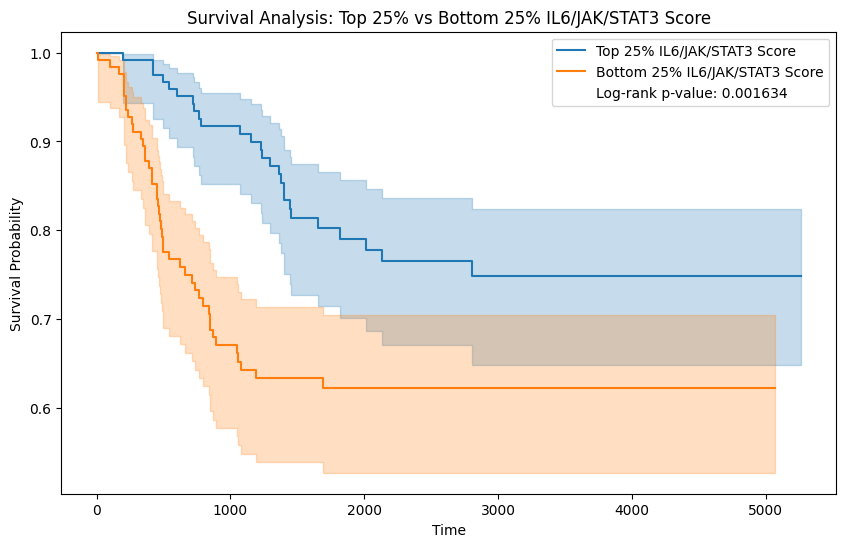

In [38]:
# Stratify samples into top 25% and bottom 25% based on il6_jak_stat3_score
top_25 = data[data['il6_jak_stat3_score'] >= data['il6_jak_stat3_score'].quantile(0.75)]
bottom_25 = data[data['il6_jak_stat3_score'] <= data['il6_jak_stat3_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IL6/JAK/STAT3 score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IL6/JAK/STAT3 Score')
ax = kmf.plot_survival_function()

# Bottom 25% IL6/JAK/STAT3 score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IL6/JAK/STAT3 Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IL6/JAK/STAT3 Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IL6/JAK/STAT3 Score', f'Bottom 25% IL6/JAK/STAT3 Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.27
         time fit was run = 2024-06-10 14:46:09 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
il6_jak_stat3_score  -0.51       0.60       0.11            -0.72            -0.30                 0.49                 0.74

                      cmp to     z      p   -log2(p)
covariate                                           
il6_jak_stat3_score     0.00 -4.81 <0.005      19.34
---
Concordance = 0.62
Partial AIC = 1234.55
log-likelihood ratio test = 20.62 on 1 df
-log2(p) of ll-ratio test = 17.45

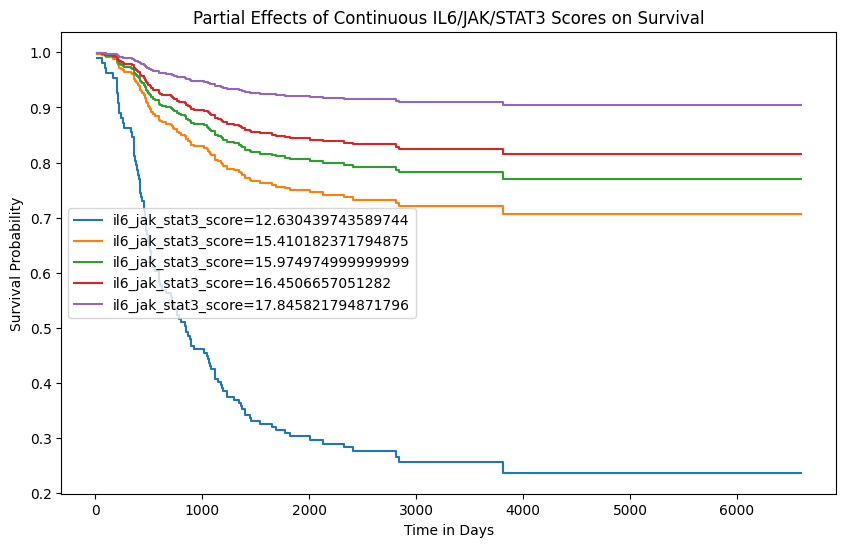

In [39]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'il6_jak_stat3_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IL6/JAK/STAT3 scores on survival
cph.plot_partial_effects_on_outcome(covariates='il6_jak_stat3_score', values=[cox_data['il6_jak_stat3_score'].min(), cox_data['il6_jak_stat3_score'].quantile(0.25), cox_data['il6_jak_stat3_score'].median(), cox_data['il6_jak_stat3_score'].quantile(0.75), cox_data['il6_jak_stat3_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IL6/JAK/STAT3 Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Inflamatory Pathway

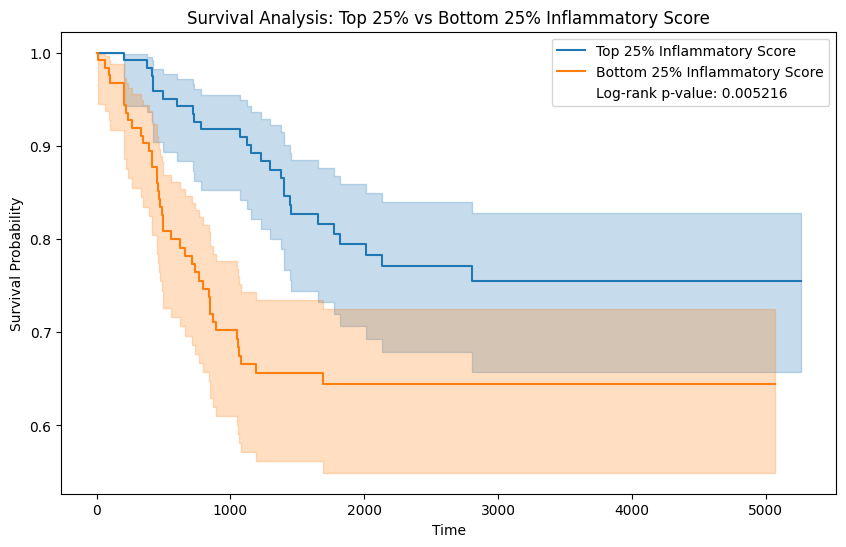

In [40]:
# Stratify samples into top 25% and bottom 25% based on inflammatory_score
top_25 = data[data['inflammatory_score'] >= data['inflammatory_score'].quantile(0.75)]
bottom_25 = data[data['inflammatory_score'] <= data['inflammatory_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% Inflammatory score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% Inflammatory Score')
ax = kmf.plot_survival_function()

# Bottom 25% Inflammatory score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% Inflammatory Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% Inflammatory Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% Inflammatory Score', f'Bottom 25% Inflammatory Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -616.25
         time fit was run = 2024-06-10 14:46:10 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
inflammatory_score  -0.51       0.60       0.11            -0.72            -0.30                 0.49                 0.74

                     cmp to     z      p   -log2(p)
covariate                                          
inflammatory_score     0.00 -4.83 <0.005      19.46
---
Concordance = 0.62
Partial AIC = 1234.49
log-likelihood ratio test = 20.67 on 1 df
-log2(p) of ll-ratio test = 17.49

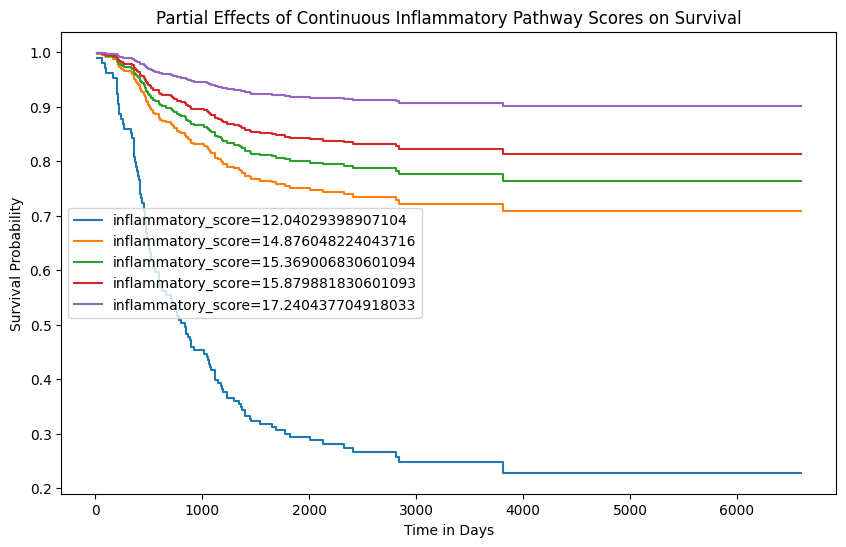

In [41]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'inflammatory_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of Inflammatory Pathway scores on survival
cph.plot_partial_effects_on_outcome(covariates='inflammatory_score', values=[cox_data['inflammatory_score'].min(), cox_data['inflammatory_score'].quantile(0.25), cox_data['inflammatory_score'].median(), cox_data['inflammatory_score'].quantile(0.75), cox_data['inflammatory_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous Inflammatory Pathway Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Alpha

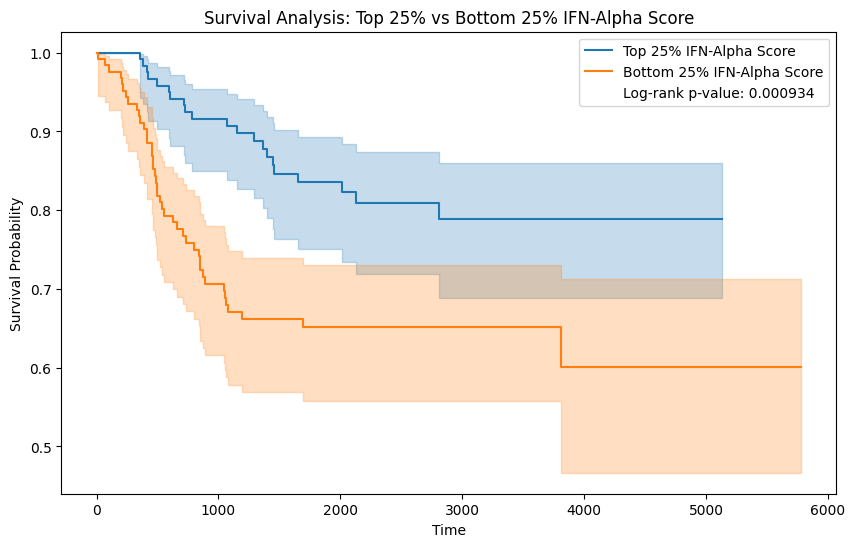

In [42]:
# Stratify samples into top 25% and bottom 25% based on IFN-Alpha score
top_25 = data[data['ifna_score'] >= data['ifna_score'].quantile(0.75)]
bottom_25 = data[data['ifna_score'] <= data['ifna_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Alpha score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Alpha Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Alpha score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Alpha Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Alpha Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Alpha Score', f'Bottom 25% IFN-Alpha Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -618.26
         time fit was run = 2024-06-10 14:46:10 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
ifna_score  -0.55       0.58       0.14            -0.82            -0.29                 0.44                 0.75

             cmp to     z      p   -log2(p)
covariate                                  
ifna_score     0.00 -4.08 <0.005      14.43
---
Concordance = 0.62
Partial AIC = 1238.53
log-likelihood ratio test = 16.64 on 1 df
-log2(p) of ll-ratio test = 14.43

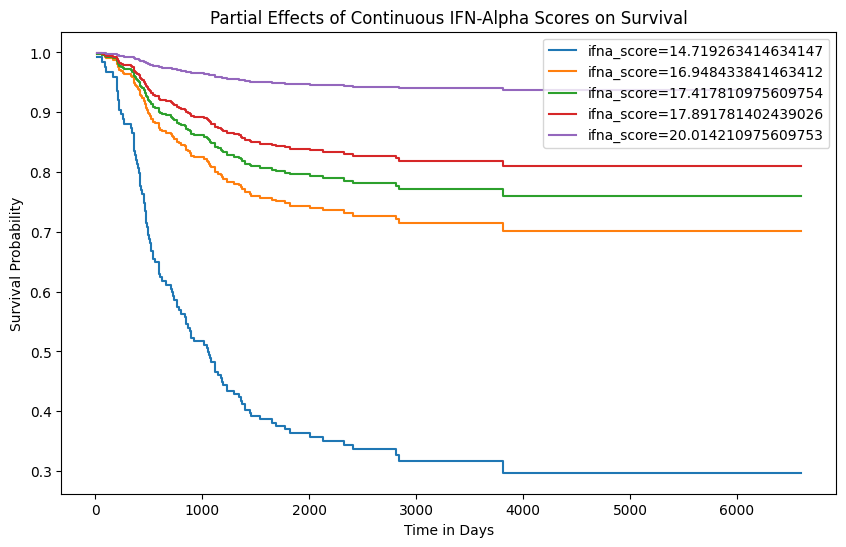

In [43]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifna_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-a scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifna_score', values=[cox_data['ifna_score'].min(), cox_data['ifna_score'].quantile(0.25), cox_data['ifna_score'].median(), cox_data['ifna_score'].quantile(0.75), cox_data['ifna_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Alpha Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### IFN-Gamma

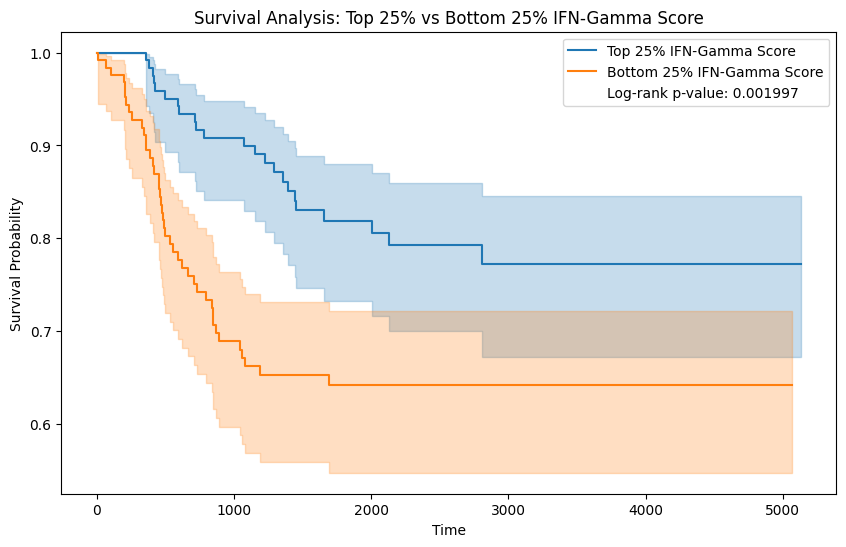

In [44]:
# Stratify samples into top 25% and bottom 25% based on IFN-Gamma score
top_25 = data[data['ifng_score'] >= data['ifng_score'].quantile(0.75)]
bottom_25 = data[data['ifng_score'] <= data['ifng_score'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% IFN-Gamma score
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% IFN-Gamma Score')
ax = kmf.plot_survival_function()

# Bottom 25% IFN-Gamma score
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% IFN-Gamma Score')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% IFN-Gamma Score')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% IFN-Gamma Score', f'Bottom 25% IFN-Gamma Score', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -615.48
         time fit was run = 2024-06-10 14:46:11 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
ifng_score  -0.63       0.53       0.13            -0.89            -0.38                 0.41                 0.69

             cmp to     z      p   -log2(p)
covariate                                  
ifng_score     0.00 -4.81 <0.005      19.36
---
Concordance = 0.63
Partial AIC = 1232.97
log-likelihood ratio test = 22.20 on 1 df
-log2(p) of ll-ratio test = 18.63

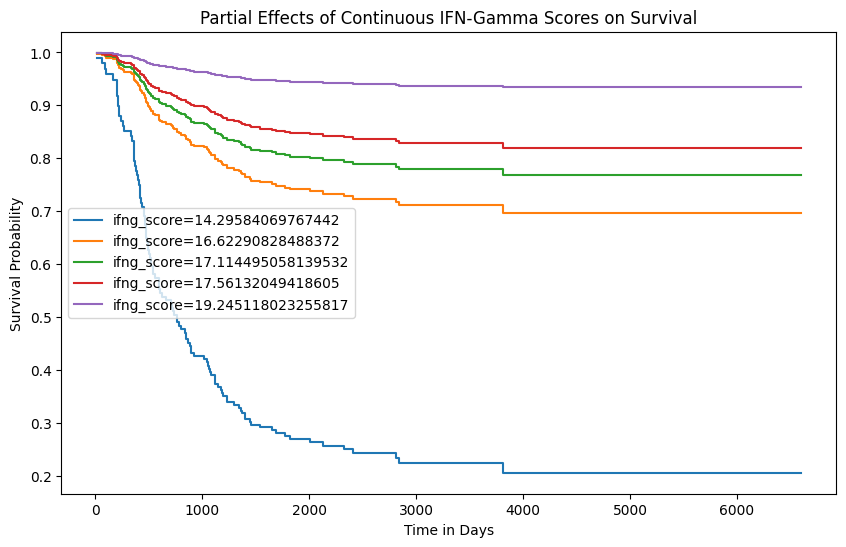

In [45]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ifng_score']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of IFN-Gamma scores on survival
cph.plot_partial_effects_on_outcome(covariates='ifng_score', values=[cox_data['ifng_score'].min(), cox_data['ifng_score'].quantile(0.25), cox_data['ifng_score'].median(), cox_data['ifng_score'].quantile(0.75), cox_data['ifng_score'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous IFN-Gamma Scores on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### Housekeeping

In [46]:
# Extract ACTB expression levels
actb_expression = gene_data.loc[gene_data['Gene'] == 'ACTB', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
actb_expression = actb_expression.reset_index()
actb_expression.columns = ['Sample ID', 'ACTB_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, actb_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ACTB_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948


In [47]:
actb_expression

,Sample ID,ACTB_expression
0,SEQC_NB001,24.7943
1,SEQC_NB002,25.2958
2,SEQC_NB003,24.5375
3,SEQC_NB004,24.6351
4,SEQC_NB005,24.9948
...,...,...
493,SEQC_NB494,25.4461
494,SEQC_NB495,25.1602
495,SEQC_NB496,25.1211
496,SEQC_NB497,24.7802


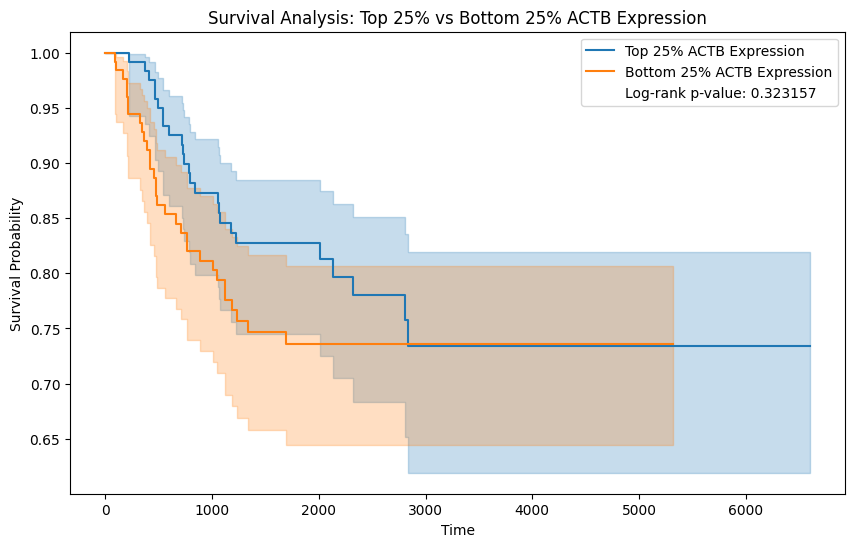

In [48]:
# Stratify samples into top 25% and bottom 25% based on ACTB expression
top_25 = data[data['ACTB_expression'] >= data['ACTB_expression'].quantile(0.75)]
bottom_25 = data[data['ACTB_expression'] <= data['ACTB_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% ACTB expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ACTB Expression')
ax = kmf.plot_survival_function()

# Bottom 25% ACTB expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ACTB Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ACTB Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ACTB Expression', f'Bottom 25% ACTB Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -625.67
         time fit was run = 2024-06-10 14:46:12 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
ACTB_expression  -0.34       0.71       0.25            -0.82             0.15                 0.44                 1.16

                  cmp to     z    p   -log2(p)
covariate                                     
ACTB_expression     0.00 -1.35 0.18       2.49
---
Concordance = 0.55
Partial AIC = 1253.35
log-likelihood ratio test = 1.82 on 1 df
-log2(p) of ll-ratio test = 2.49

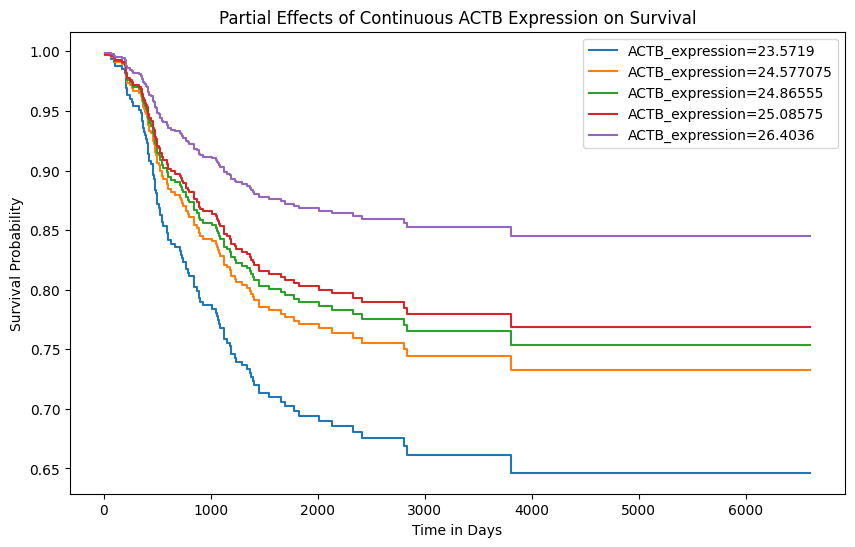

In [49]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ACTB_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='ACTB_expression', values=[cox_data['ACTB_expression'].min(), cox_data['ACTB_expression'].quantile(0.25), cox_data['ACTB_expression'].median(), cox_data['ACTB_expression'].quantile(0.75), cox_data['ACTB_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ACTB Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### TGF-Beta 1

In [50]:
# Extract ACTB expression levels
tgfb1_expression = gene_data.loc[gene_data['Gene'] == 'TGFB1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb1_expression = tgfb1_expression.reset_index()
tgfb1_expression.columns = ['Sample ID', 'TGFB1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['TGFB1_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312


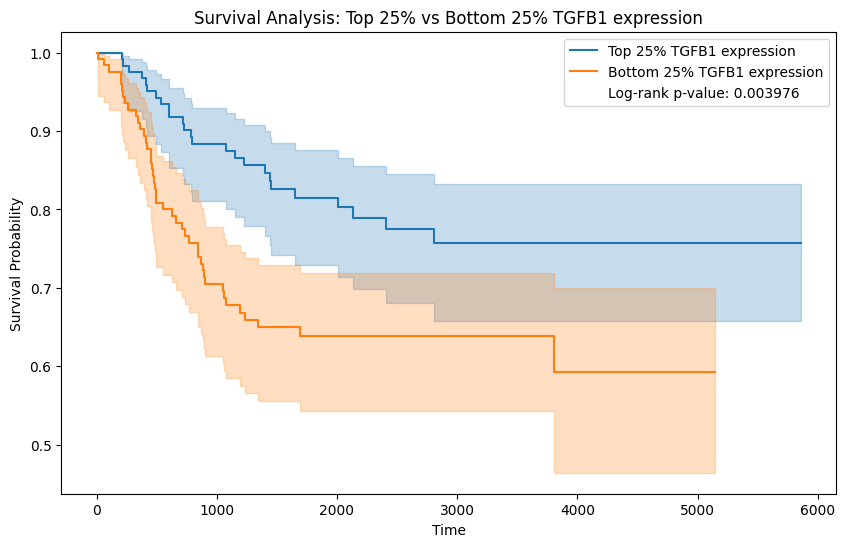

In [51]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['TGFB1_expression'] >= data['TGFB1_expression'].quantile(0.75)]
bottom_25 = data[data['TGFB1_expression'] <= data['TGFB1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFB1 expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFB1 expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFB1 expression', f'Bottom 25% TGFB1 expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -619.45
         time fit was run = 2024-06-10 14:46:13 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
TGFB1_expression  -0.41       0.66       0.10            -0.62            -0.21                 0.54                 0.81

                   cmp to     z      p   -log2(p)
covariate                                        
TGFB1_expression     0.00 -3.92 <0.005      13.44
---
Concordance = 0.60
Partial AIC = 1240.90
log-likelihood ratio test = 14.27 on 1 df
-log2(p) of ll-ratio test = 12.62

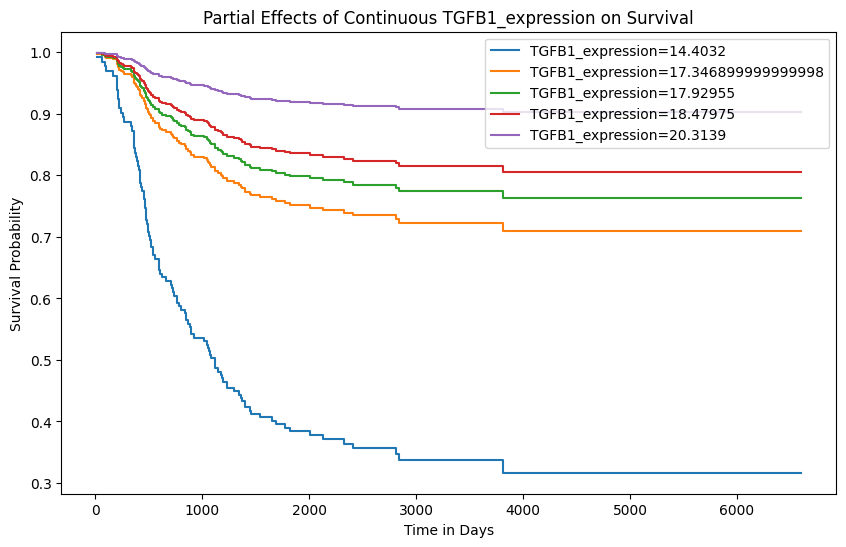

In [52]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB1_expression', values=[cox_data['TGFB1_expression'].min(), cox_data['TGFB1_expression'].quantile(0.25), cox_data['TGFB1_expression'].median(), cox_data['TGFB1_expression'].quantile(0.75), cox_data['TGFB1_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB1_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [53]:
# Identify the minimum TGFB2 expression level
min_tgfb1_expression = data['TGFB1_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['TGFB1_expression'] == min_tgfb1_expression).sum()

# Print the result
print(f"Number of patients with the lowest TGFB1 expression level ({min_tgfb1_expression}): {count_min_expression}")

Number of patients with the lowest TGFB1 expression level (14.4032): 1


In [54]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['TGFB1_expression'] == min_tgfb1_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB1 expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB1 expression level:
      Sample ID
258  SEQC_NB259


### TGF-Beta 2

In [55]:
# Extract ACTB expression levels
tgfb2_expression = gene_data.loc[gene_data['Gene'] == 'TGFB2', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb2_expression = tgfb2_expression.reset_index()
tgfb2_expression.columns = ['Sample ID', 'TGFB2_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb2_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['TGFB2_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -624.19
         time fit was run = 2024-06-10 14:46:15 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
TGFB2_expression  -0.19       0.83       0.09            -0.36            -0.02                 0.70                 0.98

                   cmp to     z    p   -log2(p)
covariate                                      
TGFB2_expression     0.00 -2.23 0.03       5.29
---
Concordance = 0.54
Partial AIC = 1250.39
log-likelihood ratio test = 4.78 on 1 df
-log2(p) of ll-ratio test = 5.12

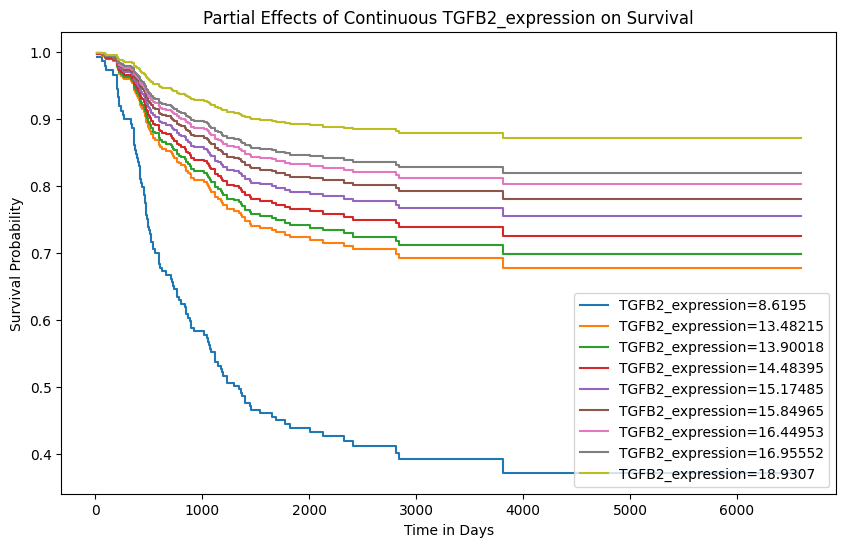

In [56]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB2_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB2_expression', values=[cox_data['TGFB2_expression'].min(),
                                                                           cox_data['TGFB2_expression'].quantile(0.05),
                                                                           cox_data['TGFB2_expression'].quantile(0.10),
                                                                           cox_data['TGFB2_expression'].quantile(0.25),
                                                                           cox_data['TGFB2_expression'].median(),
                                                                           cox_data['TGFB2_expression'].quantile(0.75),
                                                                           cox_data['TGFB2_expression'].quantile(0.90),
                                                                           cox_data['TGFB2_expression'].quantile(0.95),
                                                                           cox_data['TGFB2_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB2_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [57]:
# Identify the minimum TGFB2 expression level
min_tgfb2_expression = data['TGFB2_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['TGFB2_expression'] == min_tgfb2_expression).sum()

# Print the result
print(f"Number of patients with the lowest TGFB2 expression level ({min_tgfb2_expression}): {count_min_expression}")

Number of patients with the lowest TGFB2 expression level (8.6195): 1


In [58]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['TGFB2_expression'] == min_tgfb2_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest TGFB2 expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest TGFB2 expression level:
      Sample ID
456  SEQC_NB457


### CD8B

In [59]:
# Extract ACTB expression levels
cd8b_expression = gene_data.loc[gene_data['Gene'] == 'CD8B', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd8b_expression = cd8b_expression.reset_index()
cd8b_expression.columns = ['Sample ID', 'CD8B_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, cd8b_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['CD8B_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488


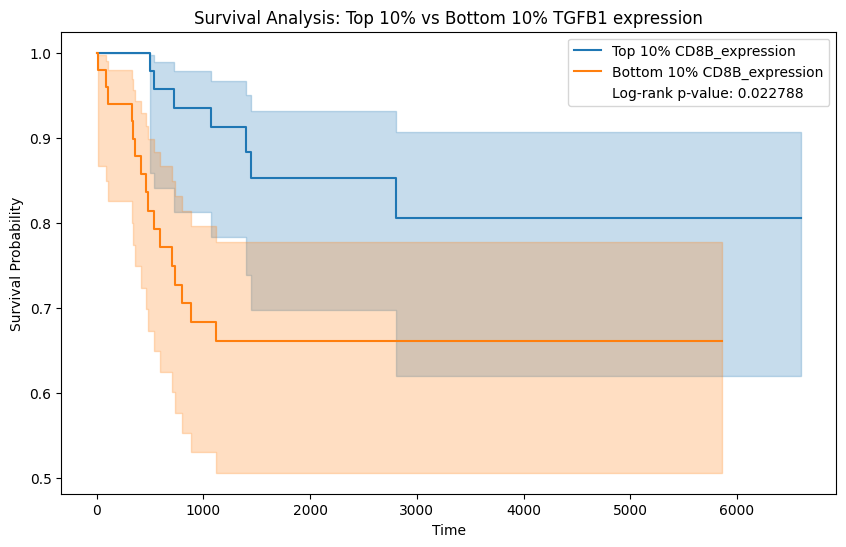

In [60]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['CD8B_expression'] >= data['CD8B_expression'].quantile(0.90)]
bottom_25 = data[data['CD8B_expression'] <= data['CD8B_expression'].quantile(0.10)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8B_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8B_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 10% vs Bottom 10% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 10% CD8B_expression', f'Bottom 10% CD8B_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

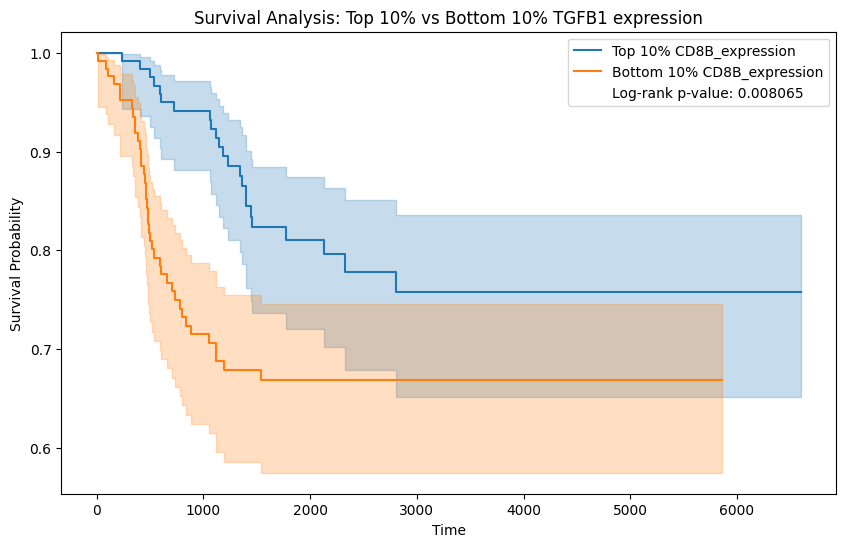

In [61]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['CD8B_expression'] >= data['CD8B_expression'].quantile(0.75)]
bottom_25 = data[data['CD8B_expression'] <= data['CD8B_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD8B_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD8B_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 10% vs Bottom 10% TGFB1 expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 10% CD8B_expression', f'Bottom 10% CD8B_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -621.88
         time fit was run = 2024-06-10 14:46:16 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
CD8B_expression  -0.19       0.83       0.06            -0.31            -0.07                 0.73                 0.93

                  cmp to     z      p   -log2(p)
covariate                                       
CD8B_expression     0.00 -3.16 <0.005       9.29
---
Concordance = 0.62
Partial AIC = 1245.75
log-likelihood ratio test = 9.41 on 1 df
-log2(p) of ll-ratio test = 8.86

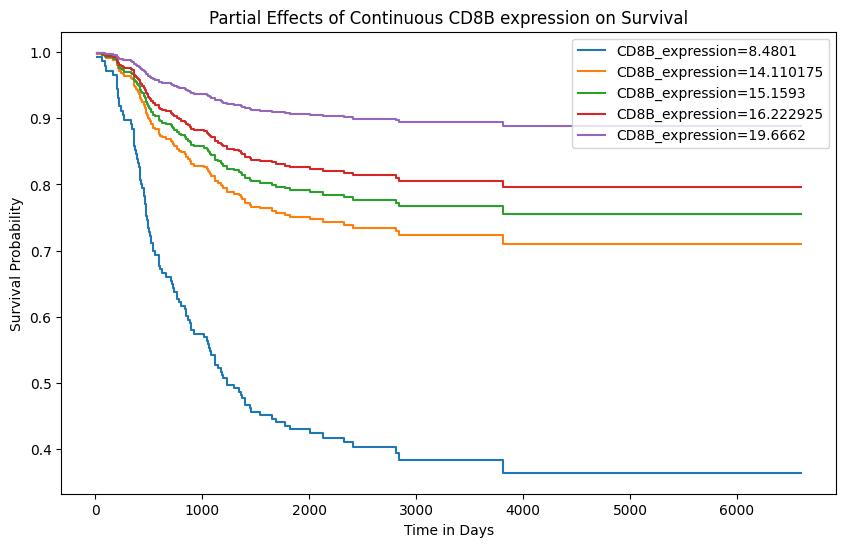

In [62]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD8B_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD8B expression on survival
cph.plot_partial_effects_on_outcome(covariates='CD8B_expression', values=[cox_data['CD8B_expression'].min(), cox_data['CD8B_expression'].quantile(0.25), cox_data['CD8B_expression'].median(), cox_data['CD8B_expression'].quantile(0.75), cox_data['CD8B_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous CD8B expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

In [63]:
# Identify the minimum CD8B expression level
min_cd8b_expression = data['CD8B_expression'].min()

# Count how many patients have this minimum expression level
count_min_expression = (data['CD8B_expression'] == min_cd8b_expression).sum()

# Print the result
print(f"Number of patients with the lowest CD8B expression level ({min_cd8b_expression}): {count_min_expression}")

Number of patients with the lowest CD8B expression level (8.4801): 1


In [64]:
# Find the patient(s) with this minimum expression level
patients_with_min_expression = data[data['CD8B_expression'] == min_cd8b_expression]

# Print the ID(s) of these patients along with the minimum expression level
print("Patient ID(s) with the lowest CD8B expression level:")
print(patients_with_min_expression[['Sample ID']])

Patient ID(s) with the lowest CD8B expression level:
      Sample ID
331  SEQC_NB332


### CD4

In [65]:
# Extract CD4 expression levels
cd4_expression = gene_data.loc[gene_data['Gene'] == 'CD4', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd4_expression = cd4_expression.reset_index()
cd4_expression.columns = ['Sample ID', 'CD4_expression']

# Map CD4 expression to the main data DataFrame
data = pd.merge(data, cd4_expression, on='Sample ID', how='left')

# Drop samples with missing CD4 expression
data.dropna(subset=['CD4_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225


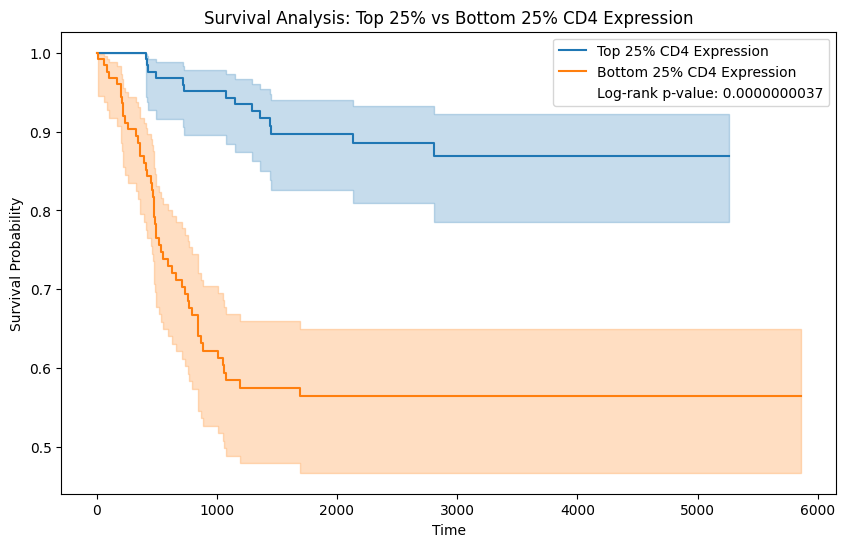

In [66]:
# Stratify samples into top 25% and bottom 25% based on CD4 expression
top_25 = data[data['CD4_expression'] >= data['CD4_expression'].quantile(0.75)]
bottom_25 = data[data['CD4_expression'] <= data['CD4_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% CD4 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD4 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% CD4 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD4 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD4 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD4 Expression', f'Bottom 25% CD4 Expression', f'Log-rank p-value: {p_value:.10f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -601.82
         time fit was run = 2024-06-10 14:46:17 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
CD4_expression  -0.54       0.58       0.07            -0.68            -0.40                 0.51                 0.67

                 cmp to     z      p   -log2(p)
covariate                                      
CD4_expression     0.00 -7.59 <0.005      44.79
---
Concordance = 0.71
Partial AIC = 1205.65
log-likelihood ratio test = 49.52 on 1 df
-log2(p) of ll-ratio test = 38.89

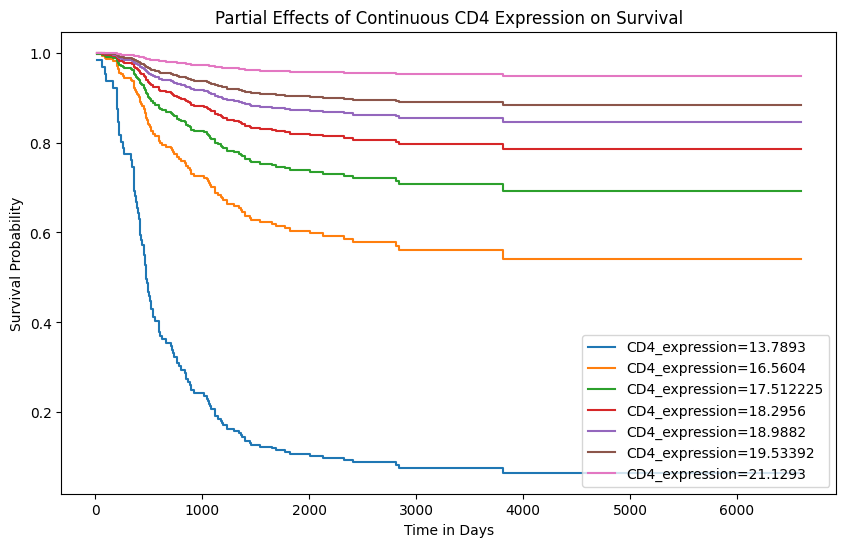

In [67]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD4_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD4 expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='CD4_expression', 
    values=[
        cox_data['CD4_expression'].min(),
        cox_data['CD4_expression'].quantile(0.10),
        cox_data['CD4_expression'].quantile(0.25), 
        cox_data['CD4_expression'].median(), 
        cox_data['CD4_expression'].quantile(0.75),
        cox_data['CD4_expression'].quantile(0.90),
        cox_data['CD4_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous CD4 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


### FOXP3

In [68]:
# Extract ACTB expression levels
foxp3_expression = gene_data.loc[gene_data['Gene'] == 'FOXP3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
foxp3_expression = foxp3_expression.reset_index()
foxp3_expression.columns = ['Sample ID', 'FOXP3_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, foxp3_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['FOXP3_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749


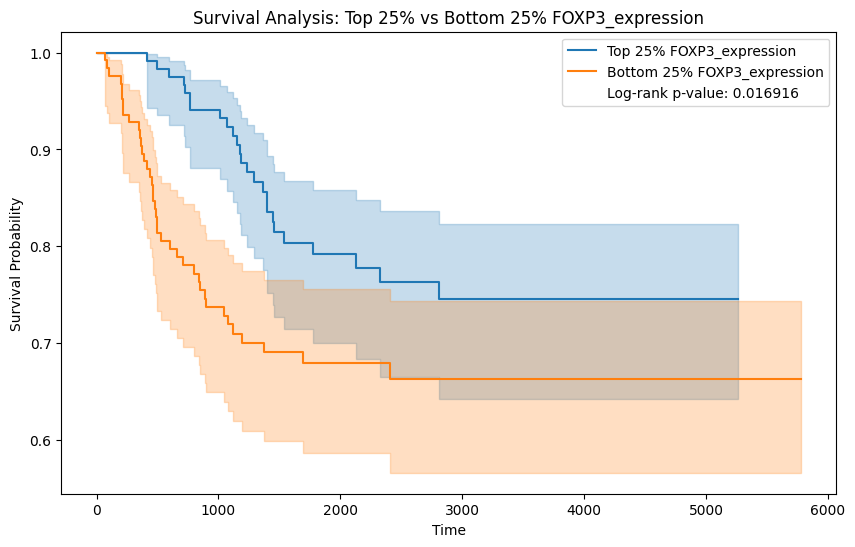

In [69]:
# Stratify samples into top 25% and bottom 25% based on TGFB1 expression
top_25 = data[data['FOXP3_expression'] >= data['FOXP3_expression'].quantile(0.75)]
bottom_25 = data[data['FOXP3_expression'] <= data['FOXP3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% FOXP3_expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% FOXP3_expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% FOXP3_expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% FOXP3_expression', f'Bottom 25% FOXP3_expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -621.12
         time fit was run = 2024-06-10 14:46:18 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
FOXP3_expression  -0.32       0.73       0.10            -0.50            -0.13                 0.60                 0.88

                   cmp to     z      p   -log2(p)
covariate                                        
FOXP3_expression     0.00 -3.33 <0.005      10.15
---
Concordance = 0.61
Partial AIC = 1244.23
log-likelihood ratio test = 10.93 on 1 df
-log2(p) of ll-ratio test = 10.05

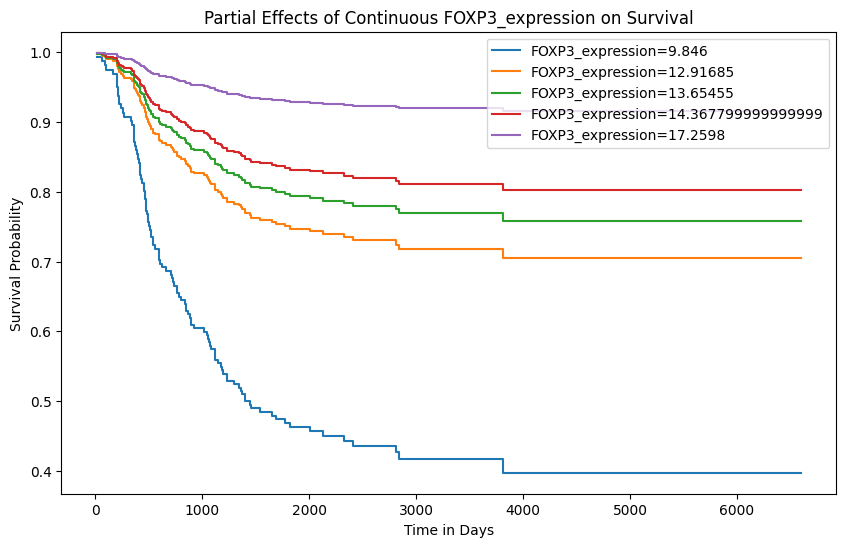

In [70]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'FOXP3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='FOXP3_expression', values=[cox_data['FOXP3_expression'].min(), cox_data['FOXP3_expression'].quantile(0.25), cox_data['FOXP3_expression'].median(), cox_data['FOXP3_expression'].quantile(0.75), cox_data['FOXP3_expression'].max()], plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous FOXP3_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### CD3E

In [71]:
# Extract CD3E expression levels
cd3e_expression = gene_data.loc[gene_data['Gene'] == 'CD3E', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd3e_expression = cd3e_expression.reset_index()
cd3e_expression.columns = ['Sample ID', 'CD3E_expression']

# Map CD3E expression to the main data DataFrame
data = pd.merge(data, cd3e_expression, on='Sample ID', how='left')

# Drop samples with missing CD3E expression
data.dropna(subset=['CD3E_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703,19.3001
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456,17.6781
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281,11.2751
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204,15.5401
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749,12.8399


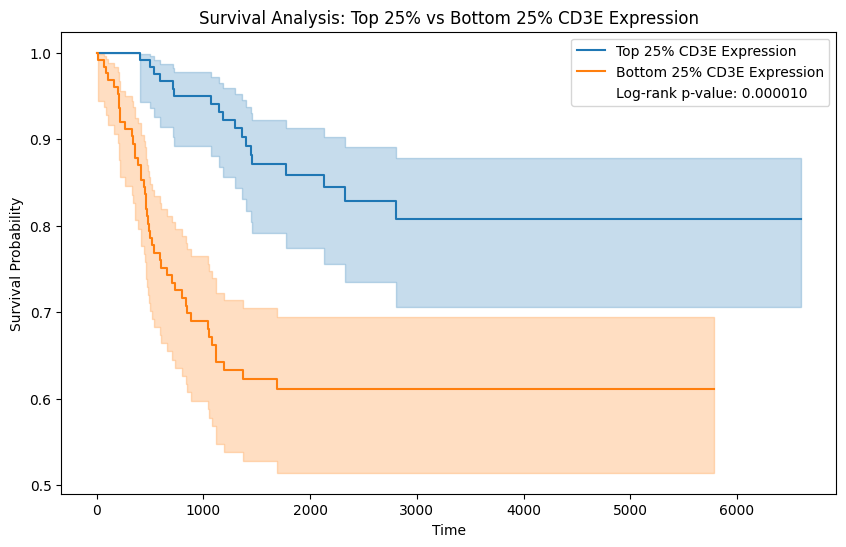

In [72]:
# Stratify samples into top 25% and bottom 25% based on CD3E expression
top_25 = data[data['CD3E_expression'] >= data['CD3E_expression'].quantile(0.75)]
bottom_25 = data[data['CD3E_expression'] <= data['CD3E_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% CD3E expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD3E Expression')
ax = kmf.plot_survival_function()

# Bottom 25% CD3E expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD3E Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD3E Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD3E Expression', f'Bottom 25% CD3E Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -609.67
         time fit was run = 2024-06-10 14:46:19 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
CD3E_expression  -0.27       0.76       0.05            -0.36            -0.19                 0.70                 0.83

                  cmp to     z      p   -log2(p)
covariate                                       
CD3E_expression     0.00 -6.07 <0.005      29.56
---
Concordance = 0.66
Partial AIC = 1221.33
log-likelihood ratio test = 33.83 on 1 df
-log2(p) of ll-ratio test = 27.31

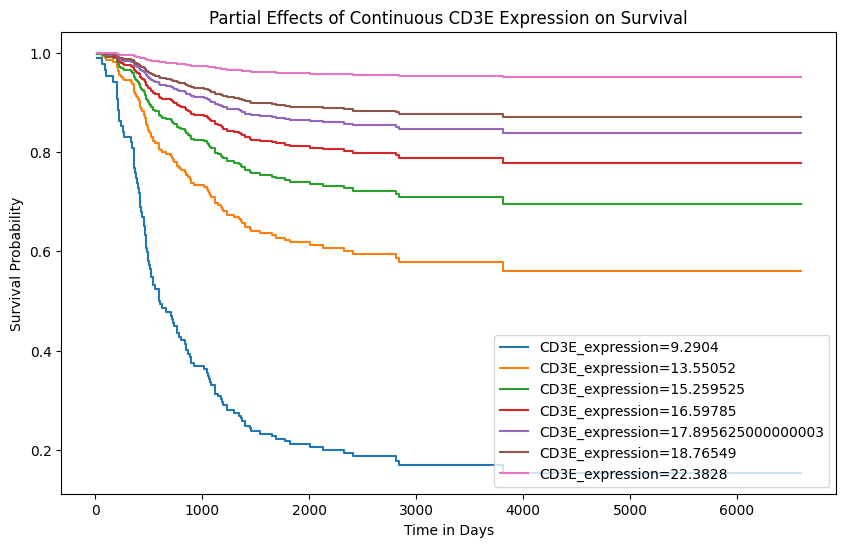

In [73]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD3E_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of CD3E expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='CD3E_expression', 
    values=[
        cox_data['CD3E_expression'].min(),
        cox_data['CD3E_expression'].quantile(0.10),
        cox_data['CD3E_expression'].quantile(0.25), 
        cox_data['CD3E_expression'].median(), 
        cox_data['CD3E_expression'].quantile(0.75),
        cox_data['CD3E_expression'].quantile(0.90),
        cox_data['CD3E_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous CD3E Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()


### PDCD1

In [74]:
# Extract PDCD1 expression levels
pdcd1_expression = gene_data.loc[gene_data['Gene'] == 'PDCD1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
pdcd1_expression = pdcd1_expression.reset_index()
pdcd1_expression.columns = ['Sample ID', 'PDCD1_expression']

# Map PDCD1 expression to the main data DataFrame
data = pd.merge(data, pdcd1_expression, on='Sample ID', how='left')

# Drop samples with missing PDCD1 expression
data.dropna(subset=['PDCD1_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703,19.3001,13.8244
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456,17.6781,13.7639
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281,11.2751,12.5989
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204,15.5401,11.5378
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749,12.8399,12.4565


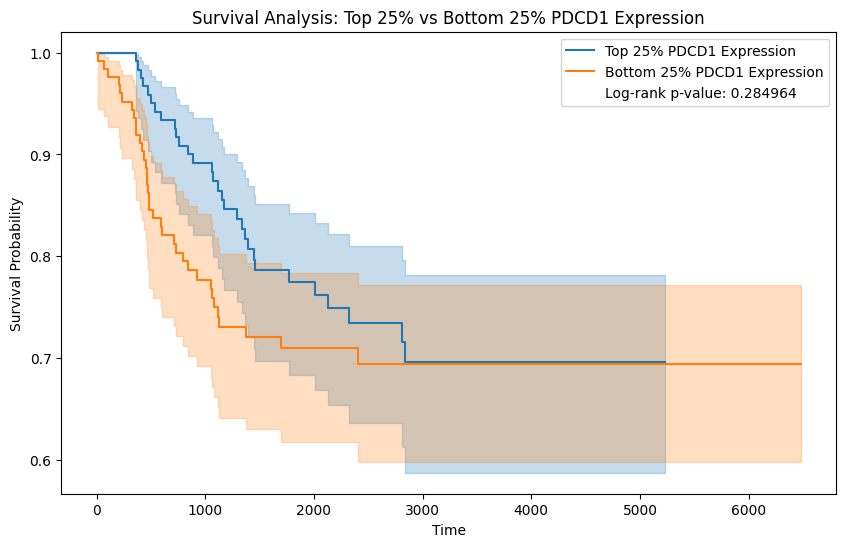

In [75]:
# Stratify samples into top 25% and bottom 25% based on PDCD1 expression
top_25 = data[data['PDCD1_expression'] >= data['PDCD1_expression'].quantile(0.75)]
bottom_25 = data[data['PDCD1_expression'] <= data['PDCD1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% PDCD1 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% PDCD1 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% PDCD1 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% PDCD1 Expression', f'Bottom 25% PDCD1 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -624.86
         time fit was run = 2024-06-10 14:46:20 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
PDCD1_expression  -0.07       0.93       0.04            -0.15            -0.00                 0.86                 1.00

                   cmp to     z    p   -log2(p)
covariate                                      
PDCD1_expression     0.00 -2.02 0.04       4.53
---
Concordance = 0.56
Partial AIC = 1251.72
log-likelihood ratio test = 3.45 on 1 df
-log2(p) of ll-ratio test = 3.98

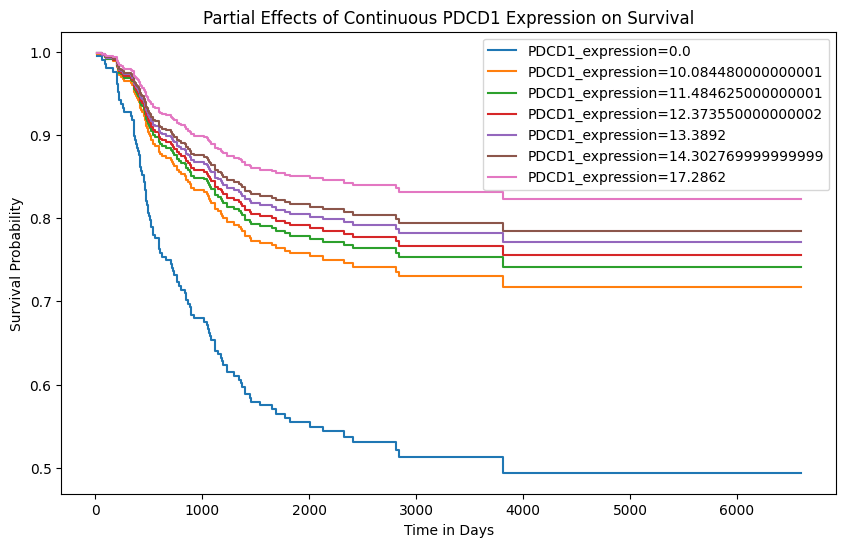

In [76]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'PDCD1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of PDCD1 expression on survival
cph.plot_partial_effects_on_outcome(
    covariates='PDCD1_expression', 
    values=[
        cox_data['PDCD1_expression'].min(),
        cox_data['PDCD1_expression'].quantile(0.10),
        cox_data['PDCD1_expression'].quantile(0.25), 
        cox_data['PDCD1_expression'].median(), 
        cox_data['PDCD1_expression'].quantile(0.75),
        cox_data['PDCD1_expression'].quantile(0.90),
        cox_data['PDCD1_expression'].max()
    ], 
    plot_baseline=False, 
    figsize=(10, 6)
)
plt.title('Partial Effects of Continuous PDCD1 Expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### ODC1

In [77]:
# Extract ACTB expression levels
odc1_expression = gene_data.loc[gene_data['Gene'] == 'ODC1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
odc1_expression = odc1_expression.reset_index()
odc1_expression.columns = ['Sample ID', 'ODC1_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, odc1_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['ODC1_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703,19.3001,13.8244,21.3850
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456,17.6781,13.7639,21.0267
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281,11.2751,12.5989,22.7247
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204,15.5401,11.5378,21.0662
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749,12.8399,12.4565,21.8427


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -585.30
         time fit was run = 2024-06-10 14:46:20 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
ODC1_expression   0.54       1.72       0.05             0.45             0.63                 1.57                 1.88

                  cmp to     z      p   -log2(p)
covariate                                       
ODC1_expression     0.00 11.62 <0.005     101.35
---
Concordance = 0.81
Partial AIC = 1172.59
log-likelihood ratio test = 82.57 on 1 df
-log2(p) of ll-ratio test = 63.09

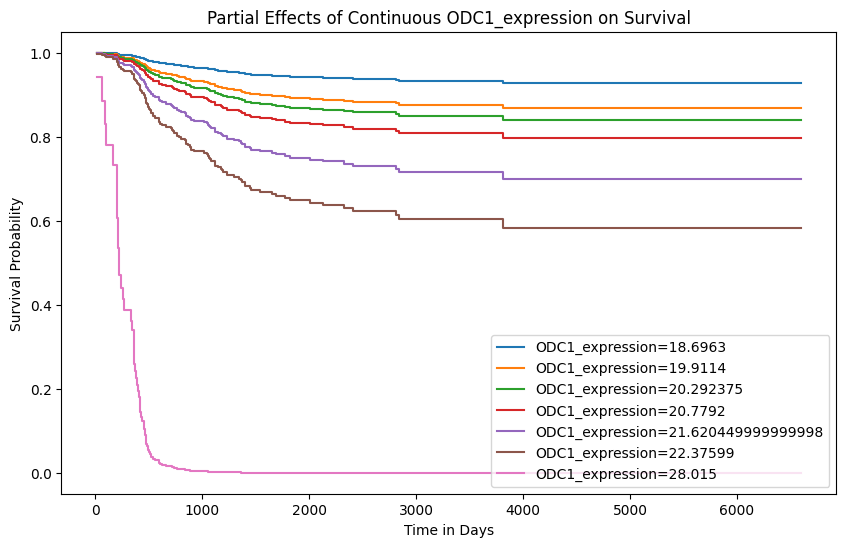

In [78]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ODC1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='ODC1_expression',values=[cox_data['ODC1_expression'].min(),
                                                                         cox_data['ODC1_expression'].quantile(0.10),
                                                                         cox_data['ODC1_expression'].quantile(0.25),
                                                                         cox_data['ODC1_expression'].median(),
                                                                         cox_data['ODC1_expression'].quantile(0.75),
                                                                         cox_data['ODC1_expression'].quantile(0.90),
                                                                         cox_data['ODC1_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ODC1_expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

### MYCN

In [79]:
# Extract MYCN expression levels
mycn_expression = gene_data.loc[gene_data['Gene'] == 'MYCN', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
mycn_expression = mycn_expression.reset_index()
mycn_expression.columns = ['Sample ID', 'MYCN_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, mycn_expression, on='Sample ID', how='left')

# Drop samples with missing ACTB expression
data.dropna(subset=['MYCN_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703,19.3001,13.8244,21.3850,18.8478
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456,17.6781,13.7639,21.0267,18.2026
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281,11.2751,12.5989,22.7247,23.4092
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204,15.5401,11.5378,21.0662,22.2447
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749,12.8399,12.4565,21.8427,23.4390


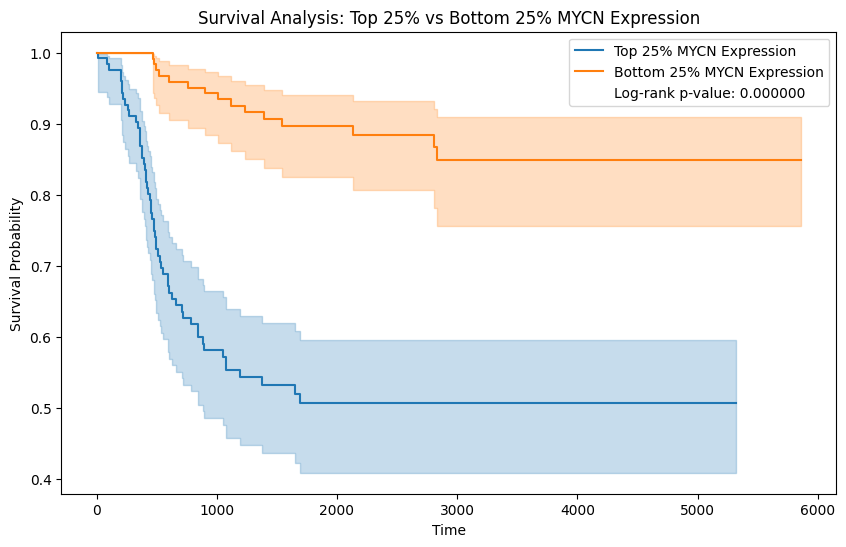

In [80]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['MYCN_expression'] >= data['MYCN_expression'].quantile(0.75)]
bottom_25 = data[data['MYCN_expression'] <= data['MYCN_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% MYCN Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% MYCN Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% MYCN Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% MYCN Expression', f'Bottom 25% MYCN Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -587.10
         time fit was run = 2024-06-10 14:46:21 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
MYCN_expression   0.41       1.51       0.04             0.33             0.50                 1.39                 1.65

                  cmp to    z      p   -log2(p)
covariate                                      
MYCN_expression     0.00 9.56 <0.005      69.51
---
Concordance = 0.71
Partial AIC = 1176.20
log-likelihood ratio test = 78.97 on 1 df
-log2(p) of ll-ratio test = 60.46

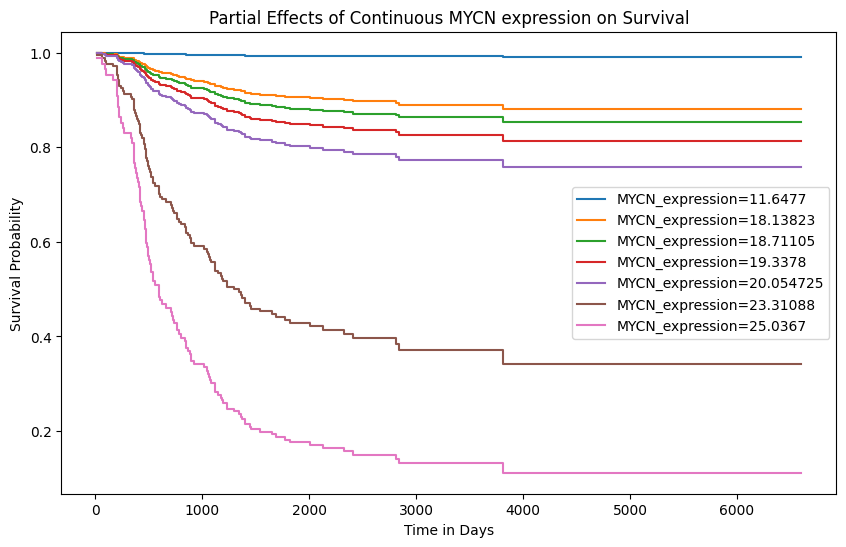

In [81]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'MYCN_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='MYCN_expression',values=[cox_data['MYCN_expression'].min(),
                                                                         cox_data['MYCN_expression'].quantile(0.10),
                                                                         cox_data['MYCN_expression'].quantile(0.25),
                                                                         cox_data['MYCN_expression'].median(),
                                                                         cox_data['MYCN_expression'].quantile(0.75),
                                                                         cox_data['MYCN_expression'].quantile(0.90),
                                                                         cox_data['MYCN_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous MYCN expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## CD274

In [82]:
# Extract CD274 expression levels
cd274_expression = gene_data.loc[gene_data['Gene'] == 'CD274', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
cd274_expression = cd274_expression.reset_index()
cd274_expression.columns = ['Sample ID', 'CD274_expression']

# Map CD274 expression to the main data DataFrame
data = pd.merge(data, cd274_expression, on='Sample ID', how='left')

# Drop samples with missing CD274 expression
data.dropna(subset=['CD274_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,TGFB1_expression,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,18.3629,13.9009,16.7351,19.4368,14.8703,19.3001,13.8244,21.3850,18.8478,15.0988
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,17.6275,13.4102,15.7871,18.6085,14.3456,17.6781,13.7639,21.0267,18.2026,14.3239
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,17.1150,16.1935,13.9106,17.0932,11.9281,11.2751,12.5989,22.7247,23.4092,11.6978
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,17.8382,17.0180,15.0802,18.2924,13.3204,15.5401,11.5378,21.0662,22.2447,14.0074
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,18.8312,16.2454,13.9488,17.4225,12.6749,12.8399,12.4565,21.8427,23.4390,12.5165


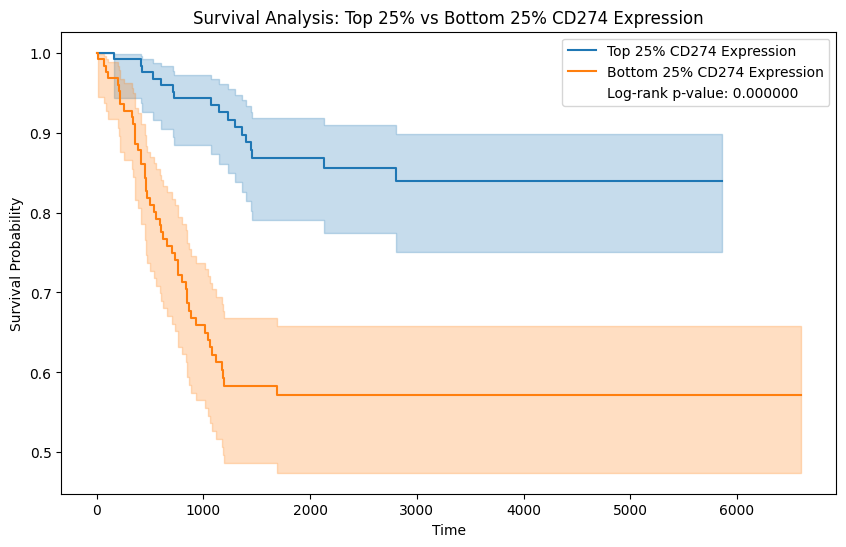

In [83]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['CD274_expression'] >= data['CD274_expression'].quantile(0.75)]
bottom_25 = data[data['CD274_expression'] <= data['CD274_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% PDCD1 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% CD274 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% PDCD1 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% CD274 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% CD274 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% CD274 Expression', f'Bottom 25% CD274 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()


<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -610.49
         time fit was run = 2024-06-10 14:46:22 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
CD274_expression  -0.41       0.66       0.07            -0.54            -0.28                 0.58                 0.75

                   cmp to     z      p   -log2(p)
covariate                                        
CD274_expression     0.00 -6.21 <0.005      30.79
---
Concordance = 0.68
Partial AIC = 1222.99
log-likelihood ratio test = 32.18 on 1 df
-log2(p) of ll-ratio test = 26.08

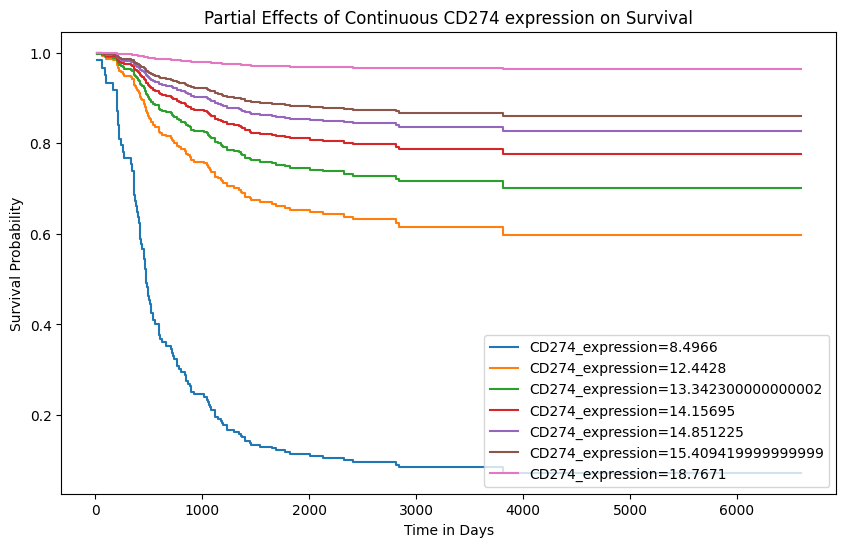

In [84]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'CD274_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='CD274_expression',values=[cox_data['CD274_expression'].min(),
                                                                         cox_data['CD274_expression'].quantile(0.10),
                                                                         cox_data['CD274_expression'].quantile(0.25),
                                                                         cox_data['CD274_expression'].median(),
                                                                         cox_data['CD274_expression'].quantile(0.75),
                                                                         cox_data['CD274_expression'].quantile(0.90),
                                                                         cox_data['CD274_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous CD274 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## TGF-Beta 3

In [85]:
# Extract TGFB3 expression levels
tgfb3_expression = gene_data.loc[gene_data['Gene'] == 'TGFB3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
tgfb3_expression = tgfb3_expression.reset_index()
tgfb3_expression.columns = ['Sample ID', 'TGFB3_expression']

# Map GAPDH expression to the main data DataFrame
data = pd.merge(data, tgfb3_expression, on='Sample ID', how='left')

# Drop samples with missing TGFB3 expression
data.dropna(subset=['TGFB3_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,...,TGFB2_expression,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression,TGFB3_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,...,13.9009,16.7351,19.4368,14.8703,19.3001,13.8244,21.3850,18.8478,15.0988,16.0817
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,...,13.4102,15.7871,18.6085,14.3456,17.6781,13.7639,21.0267,18.2026,14.3239,15.3162
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,...,16.1935,13.9106,17.0932,11.9281,11.2751,12.5989,22.7247,23.4092,11.6978,16.8757
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,...,17.0180,15.0802,18.2924,13.3204,15.5401,11.5378,21.0662,22.2447,14.0074,17.1117
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,...,16.2454,13.9488,17.4225,12.6749,12.8399,12.4565,21.8427,23.4390,12.5165,18.6260


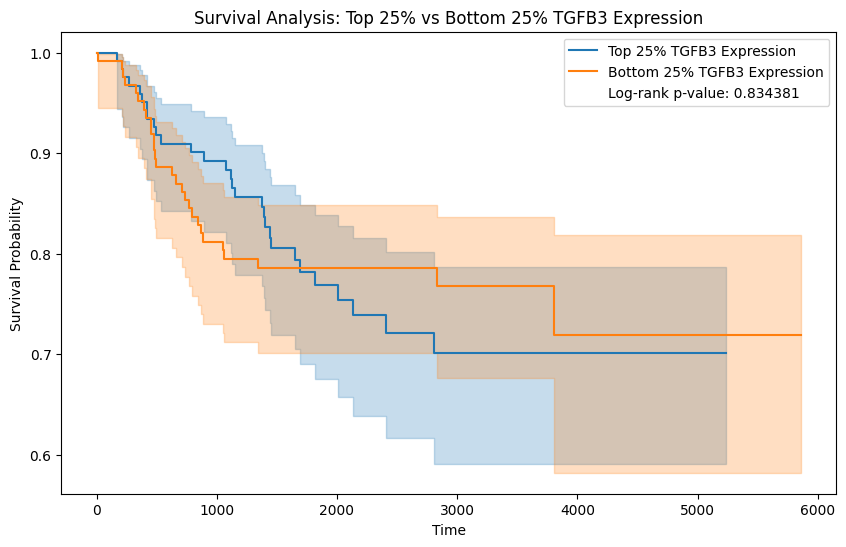

In [86]:
# Stratify samples into top 25% and bottom 25% based on MYCN expression
top_25 = data[data['TGFB3_expression'] >= data['TGFB3_expression'].quantile(0.75)]
bottom_25 = data[data['TGFB3_expression'] <= data['TGFB3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% TGFB3 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% TGFB3 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% TGFB3 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% TGFB3 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% TGFB3 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% TGFB3 Expression', f'Bottom 25% TGFB3 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -626.54
         time fit was run = 2024-06-10 14:46:23 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
TGFB3_expression  -0.03       0.97       0.10            -0.22             0.16                 0.80                 1.18

                   cmp to     z    p   -log2(p)
covariate                                      
TGFB3_expression     0.00 -0.30 0.76       0.39
---
Concordance = 0.52
Partial AIC = 1255.08
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.39

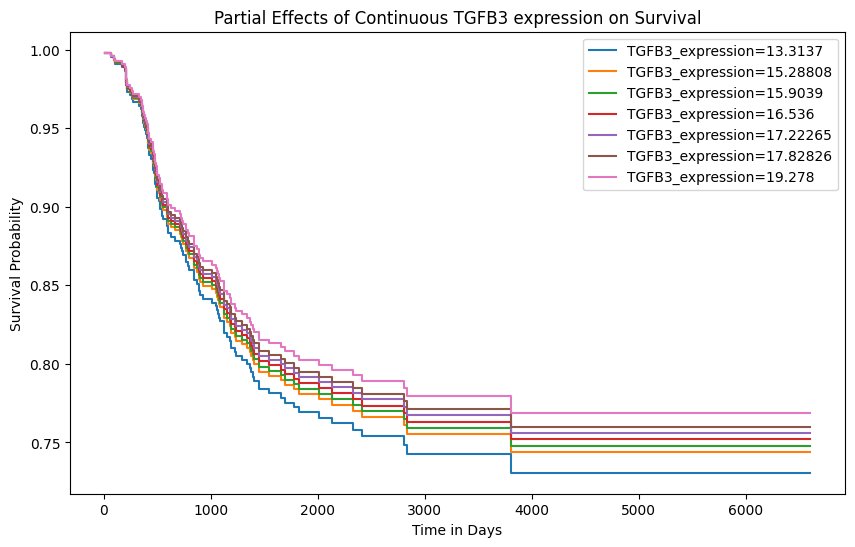

In [87]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'TGFB3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of ACTB expression on survival
cph.plot_partial_effects_on_outcome(covariates='TGFB3_expression',values=[cox_data['TGFB3_expression'].min(),
                                                                         cox_data['TGFB3_expression'].quantile(0.10),
                                                                         cox_data['TGFB3_expression'].quantile(0.25),
                                                                         cox_data['TGFB3_expression'].median(),
                                                                         cox_data['TGFB3_expression'].quantile(0.75),
                                                                         cox_data['TGFB3_expression'].quantile(0.90),
                                                                         cox_data['TGFB3_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous TGFB3 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## GNAS

In [88]:
# Extract GNAS expression levels
gnas_expression = gene_data.loc[gene_data['Gene'] == 'GNAS', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
gnas_expression = gnas_expression.reset_index()
gnas_expression.columns = ['Sample ID', 'GNAS_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, gnas_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['GNAS_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,...,CD8B_expression,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression,TGFB3_expression,GNAS_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,...,16.7351,19.4368,14.8703,19.3001,13.8244,21.3850,18.8478,15.0988,16.0817,24.1815
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,...,15.7871,18.6085,14.3456,17.6781,13.7639,21.0267,18.2026,14.3239,15.3162,24.9106
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,...,13.9106,17.0932,11.9281,11.2751,12.5989,22.7247,23.4092,11.6978,16.8757,24.7266
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,...,15.0802,18.2924,13.3204,15.5401,11.5378,21.0662,22.2447,14.0074,17.1117,24.8053
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,...,13.9488,17.4225,12.6749,12.8399,12.4565,21.8427,23.4390,12.5165,18.6260,24.9375


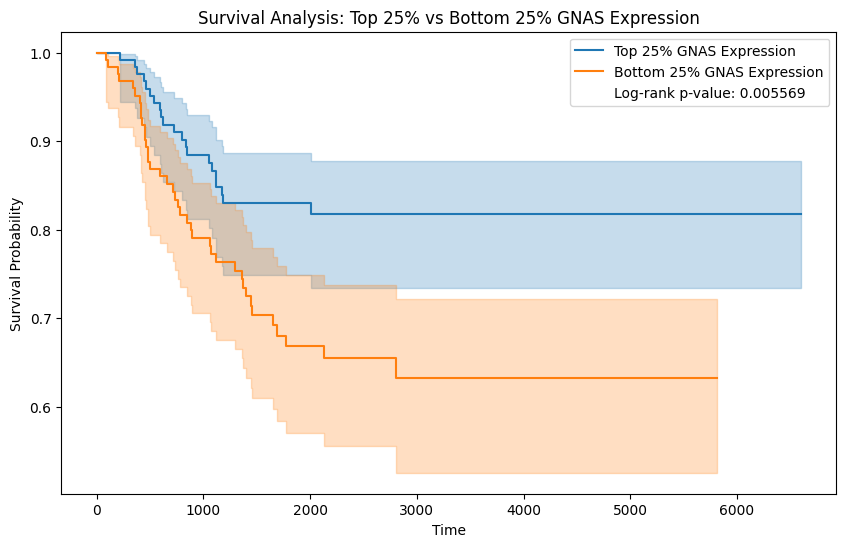

In [89]:
# Stratify samples into top 25% and bottom 25% based on GNAS expression
top_25 = data[data['GNAS_expression'] >= data['GNAS_expression'].quantile(0.75)]
bottom_25 = data[data['GNAS_expression'] <= data['GNAS_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% GNAS Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% GNAS Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% GNAS Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% GNAS Expression', f'Bottom 25% GNAS Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -620.77
         time fit was run = 2024-06-10 14:46:24 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
GNAS_expression  -0.65       0.52       0.19            -1.03            -0.27                 0.36                 0.76

                  cmp to     z      p   -log2(p)
covariate                                       
GNAS_expression     0.00 -3.39 <0.005      10.50
---
Concordance = 0.58
Partial AIC = 1243.53
log-likelihood ratio test = 11.63 on 1 df
-log2(p) of ll-ratio test = 10.59

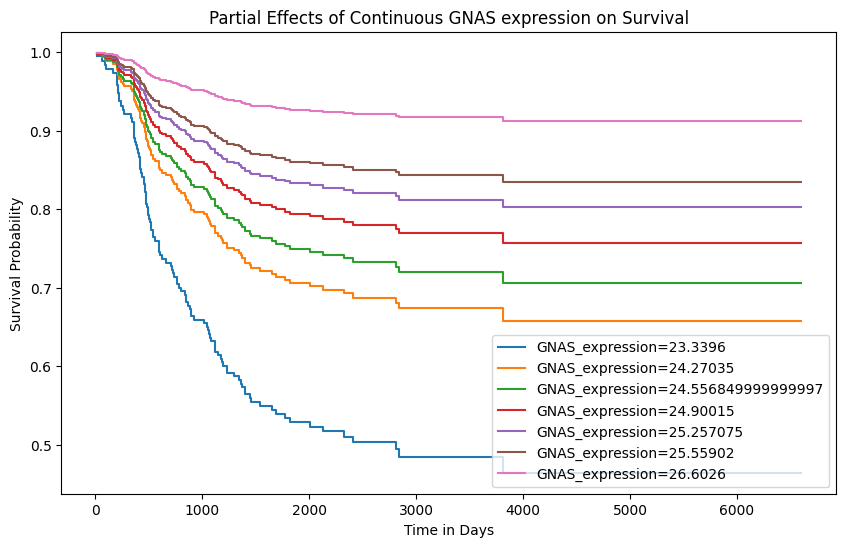

In [90]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'GNAS_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='GNAS_expression',values=[cox_data['GNAS_expression'].min(),
                                                                         cox_data['GNAS_expression'].quantile(0.10),
                                                                         cox_data['GNAS_expression'].quantile(0.25),
                                                                         cox_data['GNAS_expression'].median(),
                                                                         cox_data['GNAS_expression'].quantile(0.75),
                                                                         cox_data['GNAS_expression'].quantile(0.90),
                                                                         cox_data['GNAS_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous GNAS expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-1

In [91]:
# Extract GNAS expression levels
adrb1_expression = gene_data.loc[gene_data['Gene'] == 'ADRB1', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb1_expression = adrb1_expression.reset_index()
adrb1_expression.columns = ['Sample ID', 'ADRB1_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb1_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['ADRB1_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,...,CD4_expression,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression,TGFB3_expression,GNAS_expression,ADRB1_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,...,19.4368,14.8703,19.3001,13.8244,21.3850,18.8478,15.0988,16.0817,24.1815,0.0000
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,...,18.6085,14.3456,17.6781,13.7639,21.0267,18.2026,14.3239,15.3162,24.9106,8.1209
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,...,17.0932,11.9281,11.2751,12.5989,22.7247,23.4092,11.6978,16.8757,24.7266,8.5208
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,...,18.2924,13.3204,15.5401,11.5378,21.0662,22.2447,14.0074,17.1117,24.8053,6.8402
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,...,17.4225,12.6749,12.8399,12.4565,21.8427,23.4390,12.5165,18.6260,24.9375,0.0000


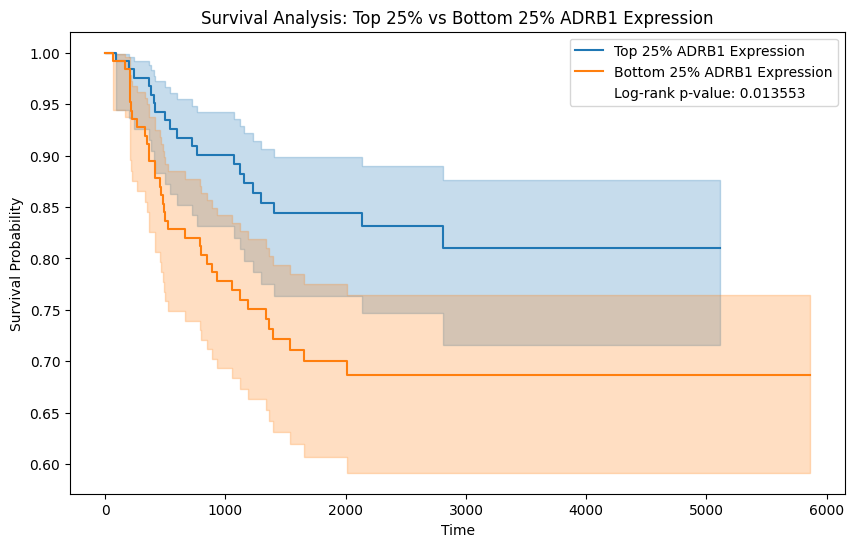

In [92]:
# Stratify samples into top 25% and bottom 25% based on ADRB1 expression
top_25 = data[data['ADRB1_expression'] >= data['ADRB1_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB1_expression'] <= data['ADRB1_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB1 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB1 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB1 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB1 Expression', f'Bottom 25% ADRB1 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -622.65
         time fit was run = 2024-06-10 14:46:25 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
ADRB1_expression  -0.07       0.93       0.02            -0.12            -0.02                 0.89                 0.98

                   cmp to     z      p   -log2(p)
covariate                                        
ADRB1_expression     0.00 -2.89 <0.005       8.04
---
Concordance = 0.57
Partial AIC = 1247.29
log-likelihood ratio test = 7.87 on 1 df
-log2(p) of ll-ratio test = 7.64

/home/jupyter-me1117/.local/lib/python3.9/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


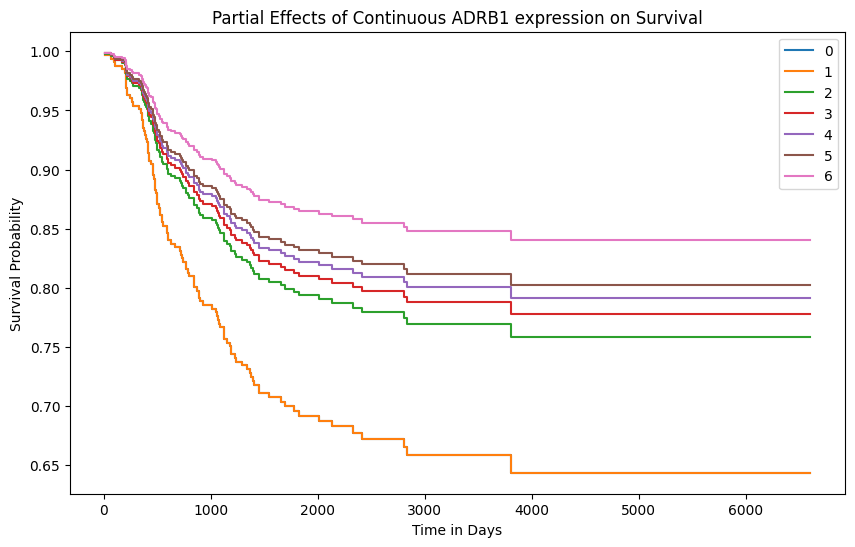

In [93]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB1_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB1_expression',values=[cox_data['ADRB1_expression'].min(),
                                                                         cox_data['ADRB1_expression'].quantile(0.10),
                                                                         cox_data['ADRB1_expression'].quantile(0.25),
                                                                         cox_data['ADRB1_expression'].median(),
                                                                         cox_data['ADRB1_expression'].quantile(0.75),
                                                                         cox_data['ADRB1_expression'].quantile(0.90),
                                                                         cox_data['ADRB1_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB1 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-2

In [94]:
# Extract GNAS expression levels
adrb2_expression = gene_data.loc[gene_data['Gene'] == 'ADRB2', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb2_expression = adrb2_expression.reset_index()
adrb2_expression.columns = ['Sample ID', 'ADRB2_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb2_expression, on='Sample ID', how='left')

# Drop samples with missing GNAS expression
data.dropna(subset=['ADRB2_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,...,FOXP3_expression,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression,TGFB3_expression,GNAS_expression,ADRB1_expression,ADRB2_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,...,14.8703,19.3001,13.8244,21.3850,18.8478,15.0988,16.0817,24.1815,0.0000,14.3614
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,...,14.3456,17.6781,13.7639,21.0267,18.2026,14.3239,15.3162,24.9106,8.1209,12.7041
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,...,11.9281,11.2751,12.5989,22.7247,23.4092,11.6978,16.8757,24.7266,8.5208,9.7105
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,...,13.3204,15.5401,11.5378,21.0662,22.2447,14.0074,17.1117,24.8053,6.8402,13.4866
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,...,12.6749,12.8399,12.4565,21.8427,23.4390,12.5165,18.6260,24.9375,0.0000,11.6505


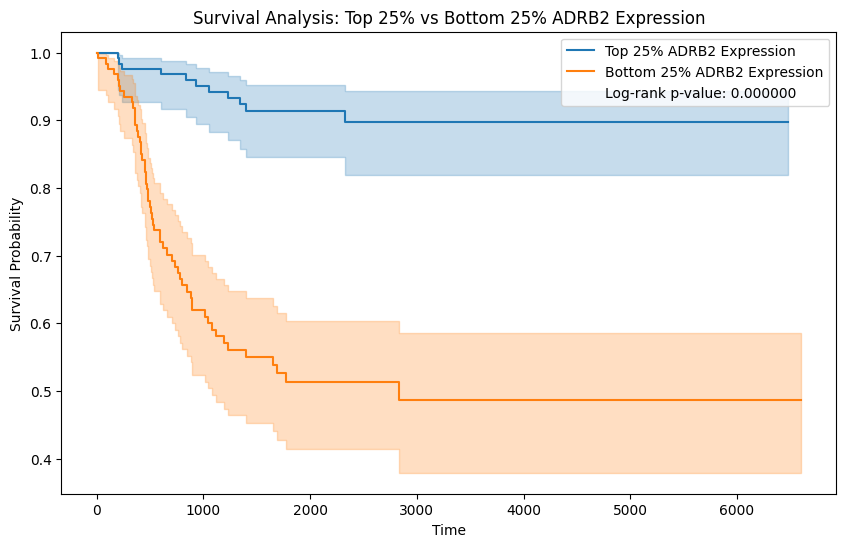

In [95]:
# Stratify samples into top 25% and bottom 25% based on ADRB1 expression
top_25 = data[data['ADRB2_expression'] >= data['ADRB2_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB2_expression'] <= data['ADRB2_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% GNAS expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB2 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% GNAS expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB2 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB2 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB2 Expression', f'Bottom 25% ADRB2 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -595.77
         time fit was run = 2024-06-10 14:46:25 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
ADRB2_expression  -0.25       0.78       0.03            -0.30            -0.20                 0.74                 0.82

                   cmp to     z      p   -log2(p)
covariate                                        
ADRB2_expression     0.00 -9.74 <0.005      72.13
---
Concordance = 0.73
Partial AIC = 1193.54
log-likelihood ratio test = 61.63 on 1 df
-log2(p) of ll-ratio test = 47.78

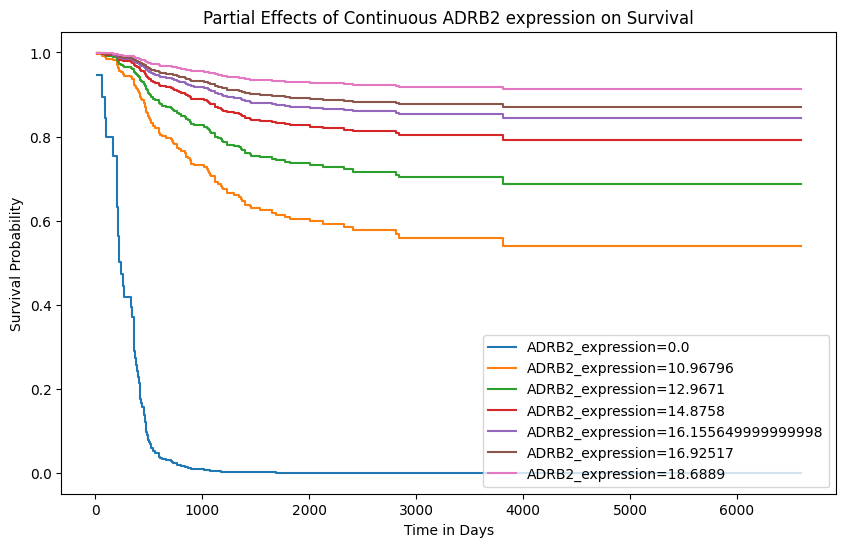

In [96]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB2_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB2_expression',values=[cox_data['ADRB2_expression'].min(),
                                                                         cox_data['ADRB2_expression'].quantile(0.10),
                                                                         cox_data['ADRB2_expression'].quantile(0.25),
                                                                         cox_data['ADRB2_expression'].median(),
                                                                         cox_data['ADRB2_expression'].quantile(0.75),
                                                                         cox_data['ADRB2_expression'].quantile(0.90),
                                                                         cox_data['ADRB2_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB2 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

## ADRB-3

In [97]:
# Extract ADRB3 expression levels
adrb3_expression = gene_data.loc[gene_data['Gene'] == 'ADRB3', gene_data.columns[8:]].squeeze()

# Convert the Series to a DataFrame and reset index to turn the indices into a column
adrb3_expression = adrb3_expression.reset_index()
adrb3_expression.columns = ['Sample ID', 'ADRB3_expression']

# Map GNAS expression to the main data DataFrame
data = pd.merge(data, adrb3_expression, on='Sample ID', how='left')

# Drop samples with missing ADRB3 expression
data.dropna(subset=['ADRB3_expression'], inplace=True)

# Verify the data structure
data.head()

,Sample ID,os days,os bin,tgfb_score,il2_stat5_score,il6_jak_stat3_score,inflammatory_score,ifna_score,ifng_score,ACTB_expression,...,CD3E_expression,PDCD1_expression,ODC1_expression,MYCN_expression,CD274_expression,TGFB3_expression,GNAS_expression,ADRB1_expression,ADRB2_expression,ADRB3_expression
0,SEQC_NB001,1362,1,18.269337,17.244859,16.482722,15.634172,18.813415,18.199822,24.7943,...,19.3001,13.8244,21.3850,18.8478,15.0988,16.0817,24.1815,0.0000,14.3614,0.0000
1,SEQC_NB002,2836,1,17.887488,16.696371,15.697078,15.270535,17.277249,17.047478,25.2958,...,17.6781,13.7639,21.0267,18.2026,14.3239,15.3162,24.9106,8.1209,12.7041,9.0355
2,SEQC_NB003,1191,1,17.871847,16.120460,14.869950,14.382875,16.387085,16.125509,24.5375,...,11.2751,12.5989,22.7247,23.4092,11.6978,16.8757,24.7266,8.5208,9.7105,9.4976
3,SEQC_NB004,2046,0,18.281798,17.053701,15.792001,15.186789,17.403907,17.065319,24.6351,...,15.5401,11.5378,21.0662,22.2447,14.0074,17.1117,24.8053,6.8402,13.4866,9.4368
4,SEQC_NB005,220,1,18.154788,16.878057,15.197942,15.045142,17.422367,16.811052,24.9948,...,12.8399,12.4565,21.8427,23.4390,12.5165,18.6260,24.9375,0.0000,11.6505,9.7566


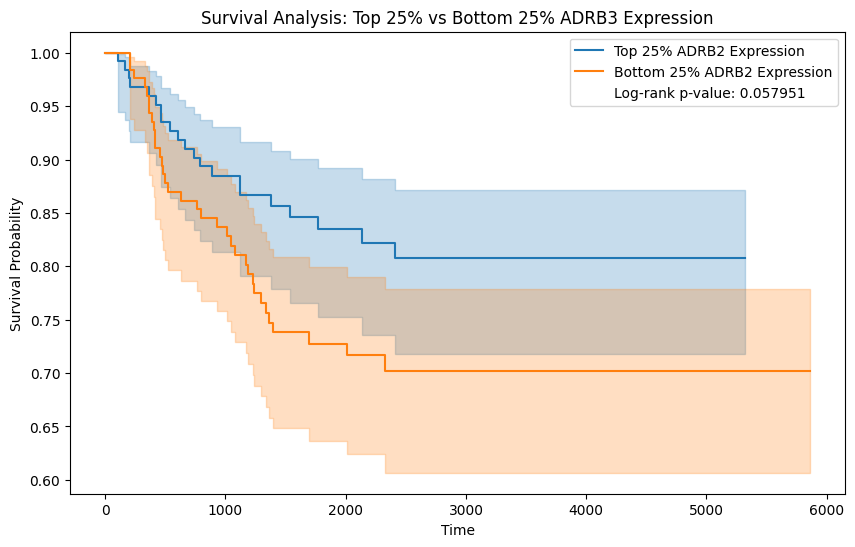

In [98]:
# Stratify samples into top 25% and bottom 25% based on ADRB3 expression
top_25 = data[data['ADRB3_expression'] >= data['ADRB3_expression'].quantile(0.75)]
bottom_25 = data[data['ADRB3_expression'] <= data['ADRB3_expression'].quantile(0.25)]

# Kaplan-Meier survival analysis
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# Top 25% ADRB3 expression
kmf.fit(top_25['os days'], top_25['os bin'], label='Top 25% ADRB3 Expression')
ax = kmf.plot_survival_function()

# Bottom 25% ADRB3 expression
kmf.fit(bottom_25['os days'], bottom_25['os bin'], label='Bottom 25% ADRB3 Expression')
kmf.plot_survival_function(ax=ax)

# Conduct log-rank test
results = logrank_test(top_25['os days'], bottom_25['os days'], event_observed_A=top_25['os bin'], event_observed_B=bottom_25['os bin'])
p_value = results.p_value

plt.title('Survival Analysis: Top 25% vs Bottom 25% ADRB3 Expression')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# Legend with p-value
labels = [f'Top 25% ADRB2 Expression', f'Bottom 25% ADRB2 Expression', f'Log-rank p-value: {p_value:.6f}']
handles, _ = ax.get_legend_handles_labels()
handles.append(plt.Line2D([], [], color='none'))  # Add empty handle for the p-value
plt.legend(handles, labels, loc='upper right')

plt.show()

<lifelines.CoxPHFitter: fitted with 498 total observations, 393 right-censored observations>
             duration col = 'os days'
                event col = 'os bin'
      baseline estimation = breslow
   number of observations = 498
number of events observed = 105
   partial log-likelihood = -625.43
         time fit was run = 2024-06-10 14:46:26 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
ADRB3_expression  -0.03       0.97       0.02            -0.07             0.01                 0.93                 1.01

                   cmp to     z    p   -log2(p)
covariate                                      
ADRB3_expression     0.00 -1.55 0.12       3.04
---
Concordance = 0.56
Partial AIC = 1252.86
log-likelihood ratio test = 2.31 on 1 df
-log2(p) of ll-ratio test = 2.96

/home/jupyter-me1117/.local/lib/python3.9/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


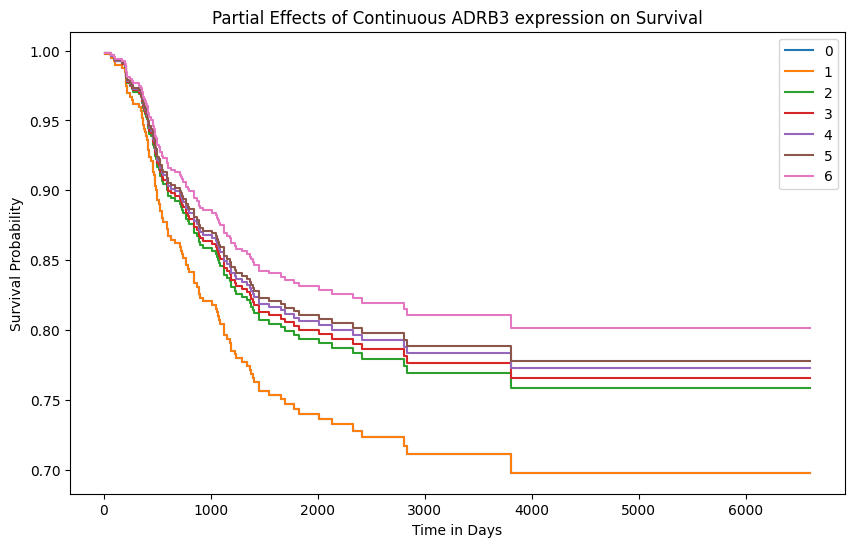

In [99]:
# Prepare the data for Cox Proportional Hazards model
cox_data = data[['os days', 'os bin', 'ADRB3_expression']].dropna()

# Instantiate the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model
cph.fit(cox_data, duration_col='os days', event_col='os bin')

# Display the results
cph.print_summary()

# Plotting the effect of GNAS expression on survival
cph.plot_partial_effects_on_outcome(covariates='ADRB3_expression',values=[cox_data['ADRB3_expression'].min(),
                                                                         cox_data['ADRB3_expression'].quantile(0.10),
                                                                         cox_data['ADRB3_expression'].quantile(0.25),
                                                                         cox_data['ADRB3_expression'].median(),
                                                                         cox_data['ADRB3_expression'].quantile(0.75),
                                                                         cox_data['ADRB3_expression'].quantile(0.90),
                                                                         cox_data['ADRB3_expression'].max()],
                                    plot_baseline=False, figsize=(10, 6))
plt.title('Partial Effects of Continuous ADRB3 expression on Survival')
plt.xlabel('Time in Days')
plt.ylabel('Survival Probability')
plt.show()

# Regression Analysis

## FOXP3 and CD4

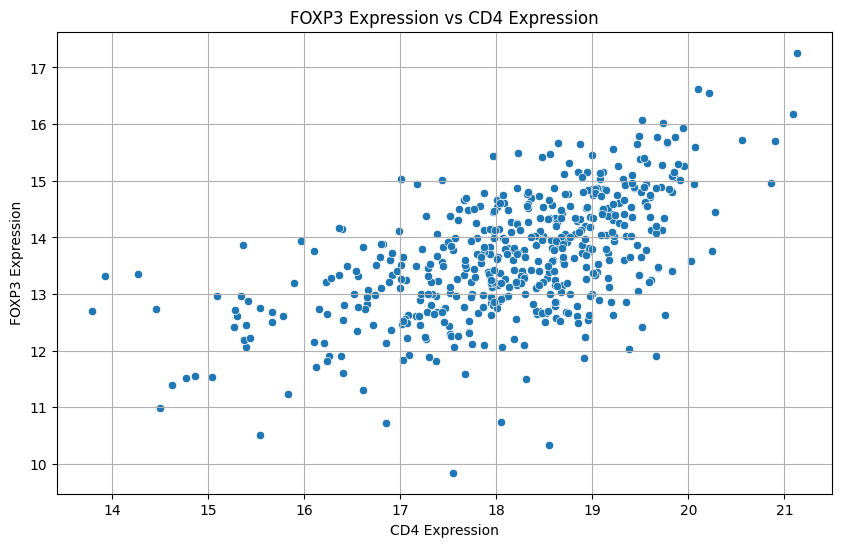

In [103]:
# Plotting FOXP3_expression vs CD4_expression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CD4_expression', y='FOXP3_expression', data=data)
plt.title('FOXP3 Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()


                            OLS Regression Results                            
Dep. Variable:       FOXP3_expression   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     249.4
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           8.28e-46
Time:                        10:56:22   Log-Likelihood:                -632.60
No. Observations:                 498   AIC:                             1269.
Df Residuals:                     496   BIC:                             1278.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.3935      0.587      7.

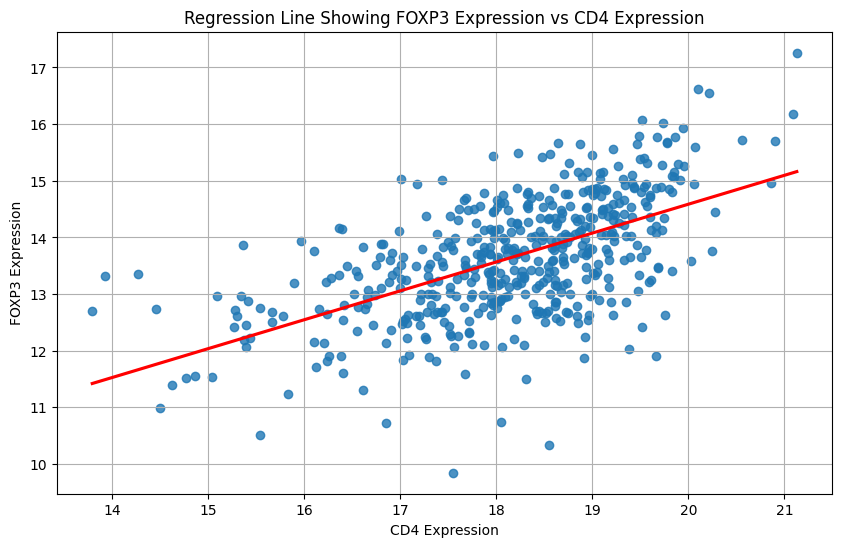

In [106]:
# Performing Regression Analysis
# Add a constant to the independent variable
X = sm.add_constant(data['CD4_expression'])
Y = data['FOXP3_expression']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

# Optional: Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='CD4_expression', y='FOXP3_expression', data=data, ci=None, line_kws={'color':'red'})
plt.title('Regression Line Showing FOXP3 Expression vs CD4 Expression')
plt.xlabel('CD4 Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

## FOXP3 and CD3E

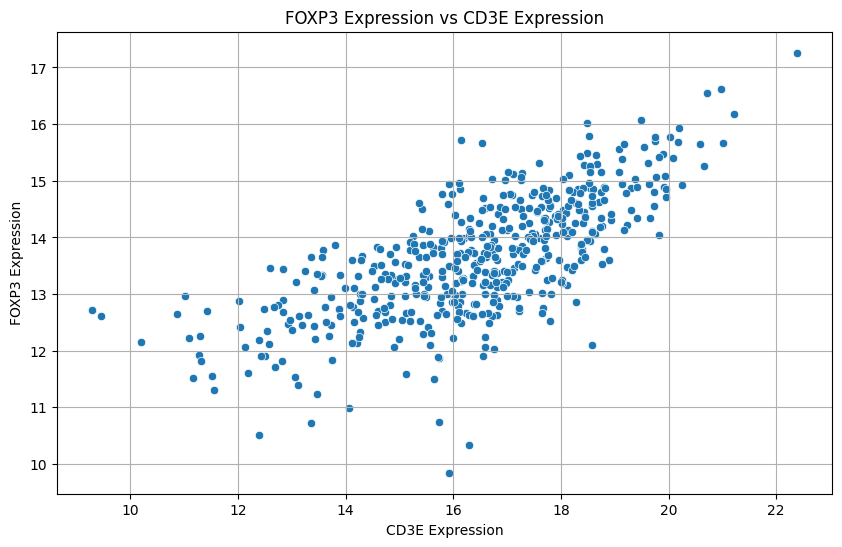

In [107]:
# Plotting FOXP3_expression vs CD3E_expression
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CD3E_expression', y='FOXP3_expression', data=data)
plt.title('FOXP3 Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:       FOXP3_expression   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     518.0
Date:                Mon, 10 Jun 2024   Prob (F-statistic):           4.85e-79
Time:                        11:06:25   Log-Likelihood:                -555.98
No. Observations:                 498   AIC:                             1116.
Df Residuals:                     496   BIC:                             1124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.6832      0.264     

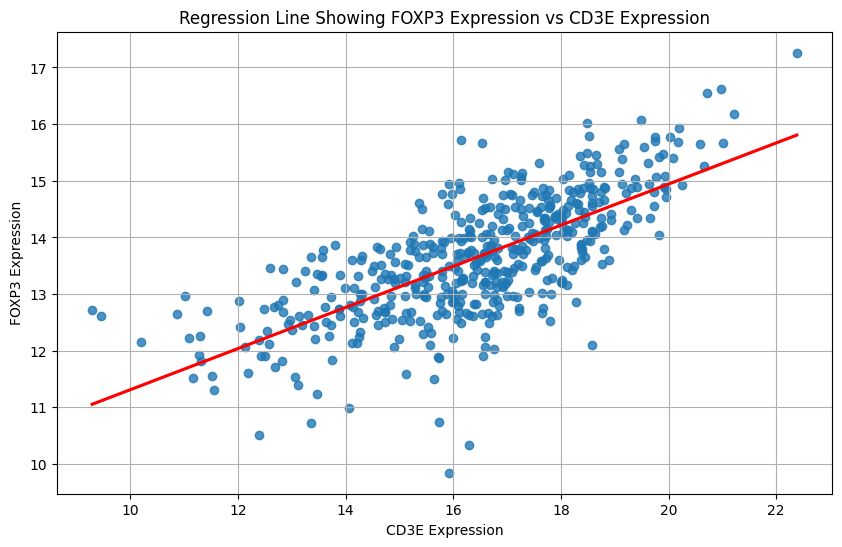

In [108]:
# Performing Regression Analysis
# Add a constant to the independent variable
X = sm.add_constant(data['CD3E_expression'])
Y = data['FOXP3_expression']

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print out the statistics
print(model.summary())

# Optional: Plot regression line on top of scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(x='CD3E_expression', y='FOXP3_expression', data=data, ci=None, line_kws={'color':'red'})
plt.title('Regression Line Showing FOXP3 Expression vs CD3E Expression')
plt.xlabel('CD3E Expression')
plt.ylabel('FOXP3 Expression')
plt.grid(True)
plt.show()